### Master Thesis - ISCTE - Masters in Data Science
#### How to improve Intrusion Detection Systems - Combining Imbalanced Learning with Anomaly Detection Algorithms
##### Tiago Manuel Alves - Student 120400

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#####  PART 3 OF 3

ANOMALY DETECTION COMPREHENSIVE ANALYSIS

This notebook implements various anomaly detection algorithms to identify
network intrusions using the HIKARI-2022 dataset. We'll use unsupervised
learning approaches and evaluate them against the known labels.

Algorithms included:
- Isolation Forest
- Local Outlier Factor (LOF)
- One-Class SVM
- DBSCAN Clustering
- Elliptic Envelope
- Auto-Encoder Neural Network (PyTorch)

The analysis maintains the same structure as traditional ML approaches
but focuses on unsupervised anomaly detection techniques.

In [2]:
# =============================================================================
# MASTERS IN DATA SCIENCE - ISCTE
# STUDENT - Tiago Manuel Alves | 120400
# ANOMALY DETECTION ANALYSIS WITH STANDARD ALGORITHMS
# Dataset: HIKARI-2022 Network Traffic Dataset
# Purpose: Comprehensive Anomaly Detection using Multiple Algorithms
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
from matplotlib.colors import is_color_like
warnings.filterwarnings('ignore')

# Anomaly Detection Algorithms
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope

# Deep Learning for Anomaly Detection
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Metrics and Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    silhouette_score, adjusted_rand_score
)

# GPU Acceleration (if available)
try:
    import cudf
    import cuml
    from cuml.ensemble import IsolationForest as cuIsolationForest
    from cuml.neighbors import NearestNeighbors as cuNearestNeighbors
    CUML_AVAILABLE = True
    print("CUML (GPU) libraries loaded successfully!")
except ImportError:
    CUML_AVAILABLE = False
    print("CUML not available, using CPU-based algorithms")

# Visualization and styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("ALL LIBRARIES IMPORTED SUCCESSFULLY!")
print("Anomaly Detection Analysis Ready")
print("Random Seed:", RANDOM_SEED)
print("=" * 70)

# Check GPU availability for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch Device: {device}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("=" * 70)

print("LIBRARY VERSIONING")
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("seaborn:", sns.__version__)
print("torch:", torch.__version__)
print("=" * 70)


CUML not available, using CPU-based algorithms
ALL LIBRARIES IMPORTED SUCCESSFULLY!
Anomaly Detection Analysis Ready
Random Seed: 42
PyTorch Device: cpu
CUDA Available: False
LIBRARY VERSIONING
pandas: 2.2.2
numpy: 2.0.2
seaborn: 0.13.2
torch: 2.8.0+cpu


# Section 1: Load the Dataset

The goal of this step is to load the dataset and understand its structure. After Running the cells below we will be able to find:
- The structure of the dataset
- The shape of the dataset (how many rows and columns)
- A quick overview of the dataset
- What kind and how many features the dataset has
- Missing values handling

In [3]:
# =============================================================================
# SECTION 1: LOAD AND INSPECT DATASET
# =============================================================================

def load_and_inspect_data_comprehensive(filepath):
    """
    Load the dataset and provide comprehensive inspection for anomaly detection

    Parameters:
    filepath (str): Path to the CSV file

    Returns:
    pd.DataFrame: Loaded dataset
    """
    print("STEP 1: LOADING AND INSPECTING DATA FOR ANOMALY DETECTION")
    print("=" * 65)

    # Load the data
    df = pd.read_csv(filepath)

    print(f"Dataset loaded successfully!")
    print(f"Original dataset shape: {df.shape}")
    print(f"Columns: {len(df.columns)} features")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Display basic info
    print("\nDATASET OVERVIEW:")
    print("-" * 30)
    print(f"Number of samples: {len(df):,}")
    print(f"Number of features: {df.shape[1]}")
    print(f"Data types: {df.dtypes.value_counts().to_dict()}")

    # Check for missing values
    print("\nMISSING VALUES CHECK:")
    print("-" * 25)
    missing_values = df.isnull().sum()
    total_missing = missing_values.sum()
    if total_missing > 0:
        print(f"Found {total_missing:,} missing values:")
        missing_features = missing_values[missing_values > 0]
        for feature, count in missing_features.items():
            print(f"   {feature}: {count:,} ({count/len(df)*100:.2f}%)")
    else:
        print("No missing values found!")

    # Data types breakdown
    print(f"\nDATA TYPES BREAKDOWN:")
    print("-" * 25)
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   {dtype}: {count} features")

    # Label analysis for anomaly detection context
    if 'Label' in df.columns:
        print(f"\nLABEL DISTRIBUTION (for evaluation purposes):")
        print("-" * 45)
        label_counts = df['Label'].value_counts()
        for label, count in label_counts.items():
            percentage = (count / len(df)) * 100
            label_name = "Normal" if label == 0 else "Anomaly"
            print(f"   {label_name} ({label}): {count:,} ({percentage:.2f}%)")

        anomaly_ratio = label_counts[1] / len(df) if 1 in label_counts else 0
        print(f"\nAnomaly Rate: {anomaly_ratio*100:.2f}%")
        if anomaly_ratio < 0.05:
            print(" Very imbalanced dataset - ideal for anomaly detection!")
        elif anomaly_ratio < 0.1:
            print(" Good imbalance ratio for anomaly detection")
        else:
            print(" High anomaly rate - consider if this is true anomaly detection")

    # Display first few rows
    print(f"\nFIRST 5 ROWS PREVIEW:")
    print("-" * 25)
    print(df.head().to_string())

    return df

# ==========================================================
# EXECUTION
# ==========================================================

# Load the dataset
df = load_and_inspect_data_comprehensive('/content/drive/MyDrive/Thesis_Work/ALLFLOWMETER_HIKARI2022.csv')


STEP 1: LOADING AND INSPECTING DATA FOR ANOMALY DETECTION
Dataset loaded successfully!
Original dataset shape: (228253, 88)
Columns: 88 features
Memory usage: 213.15 MB

DATASET OVERVIEW:
------------------------------
Number of samples: 228,253
Number of features: 88
Data types: {dtype('float64'): 55, dtype('int64'): 28, dtype('O'): 5}

MISSING VALUES CHECK:
-------------------------
No missing values found!

DATA TYPES BREAKDOWN:
-------------------------
   float64: 55 features
   int64: 28 features
   object: 5 features

LABEL DISTRIBUTION (for evaluation purposes):
---------------------------------------------
   Normal (0): 214,904 (94.15%)
   Anomaly (1): 13,349 (5.85%)

Anomaly Rate: 5.85%
 Good imbalance ratio for anomaly detection

FIRST 5 ROWS PREVIEW:
-------------------------
   Unnamed: 0                 uid       originh  originp          responh  responp           flow_duration  fwd_pkts_tot  bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  bwd_pkts

# Section 2: Comprehensive Dataset Visualization

The goal of this section is to analyze the variables that we have and how imbalanced the dataset is. After Running the cells below we will be able to find:
- Have a visual overview of dataset
- Calculate the Anomaly Rate (if any)



STEP 2: COMPREHENSIVE DATASET VISUALIZATIONS


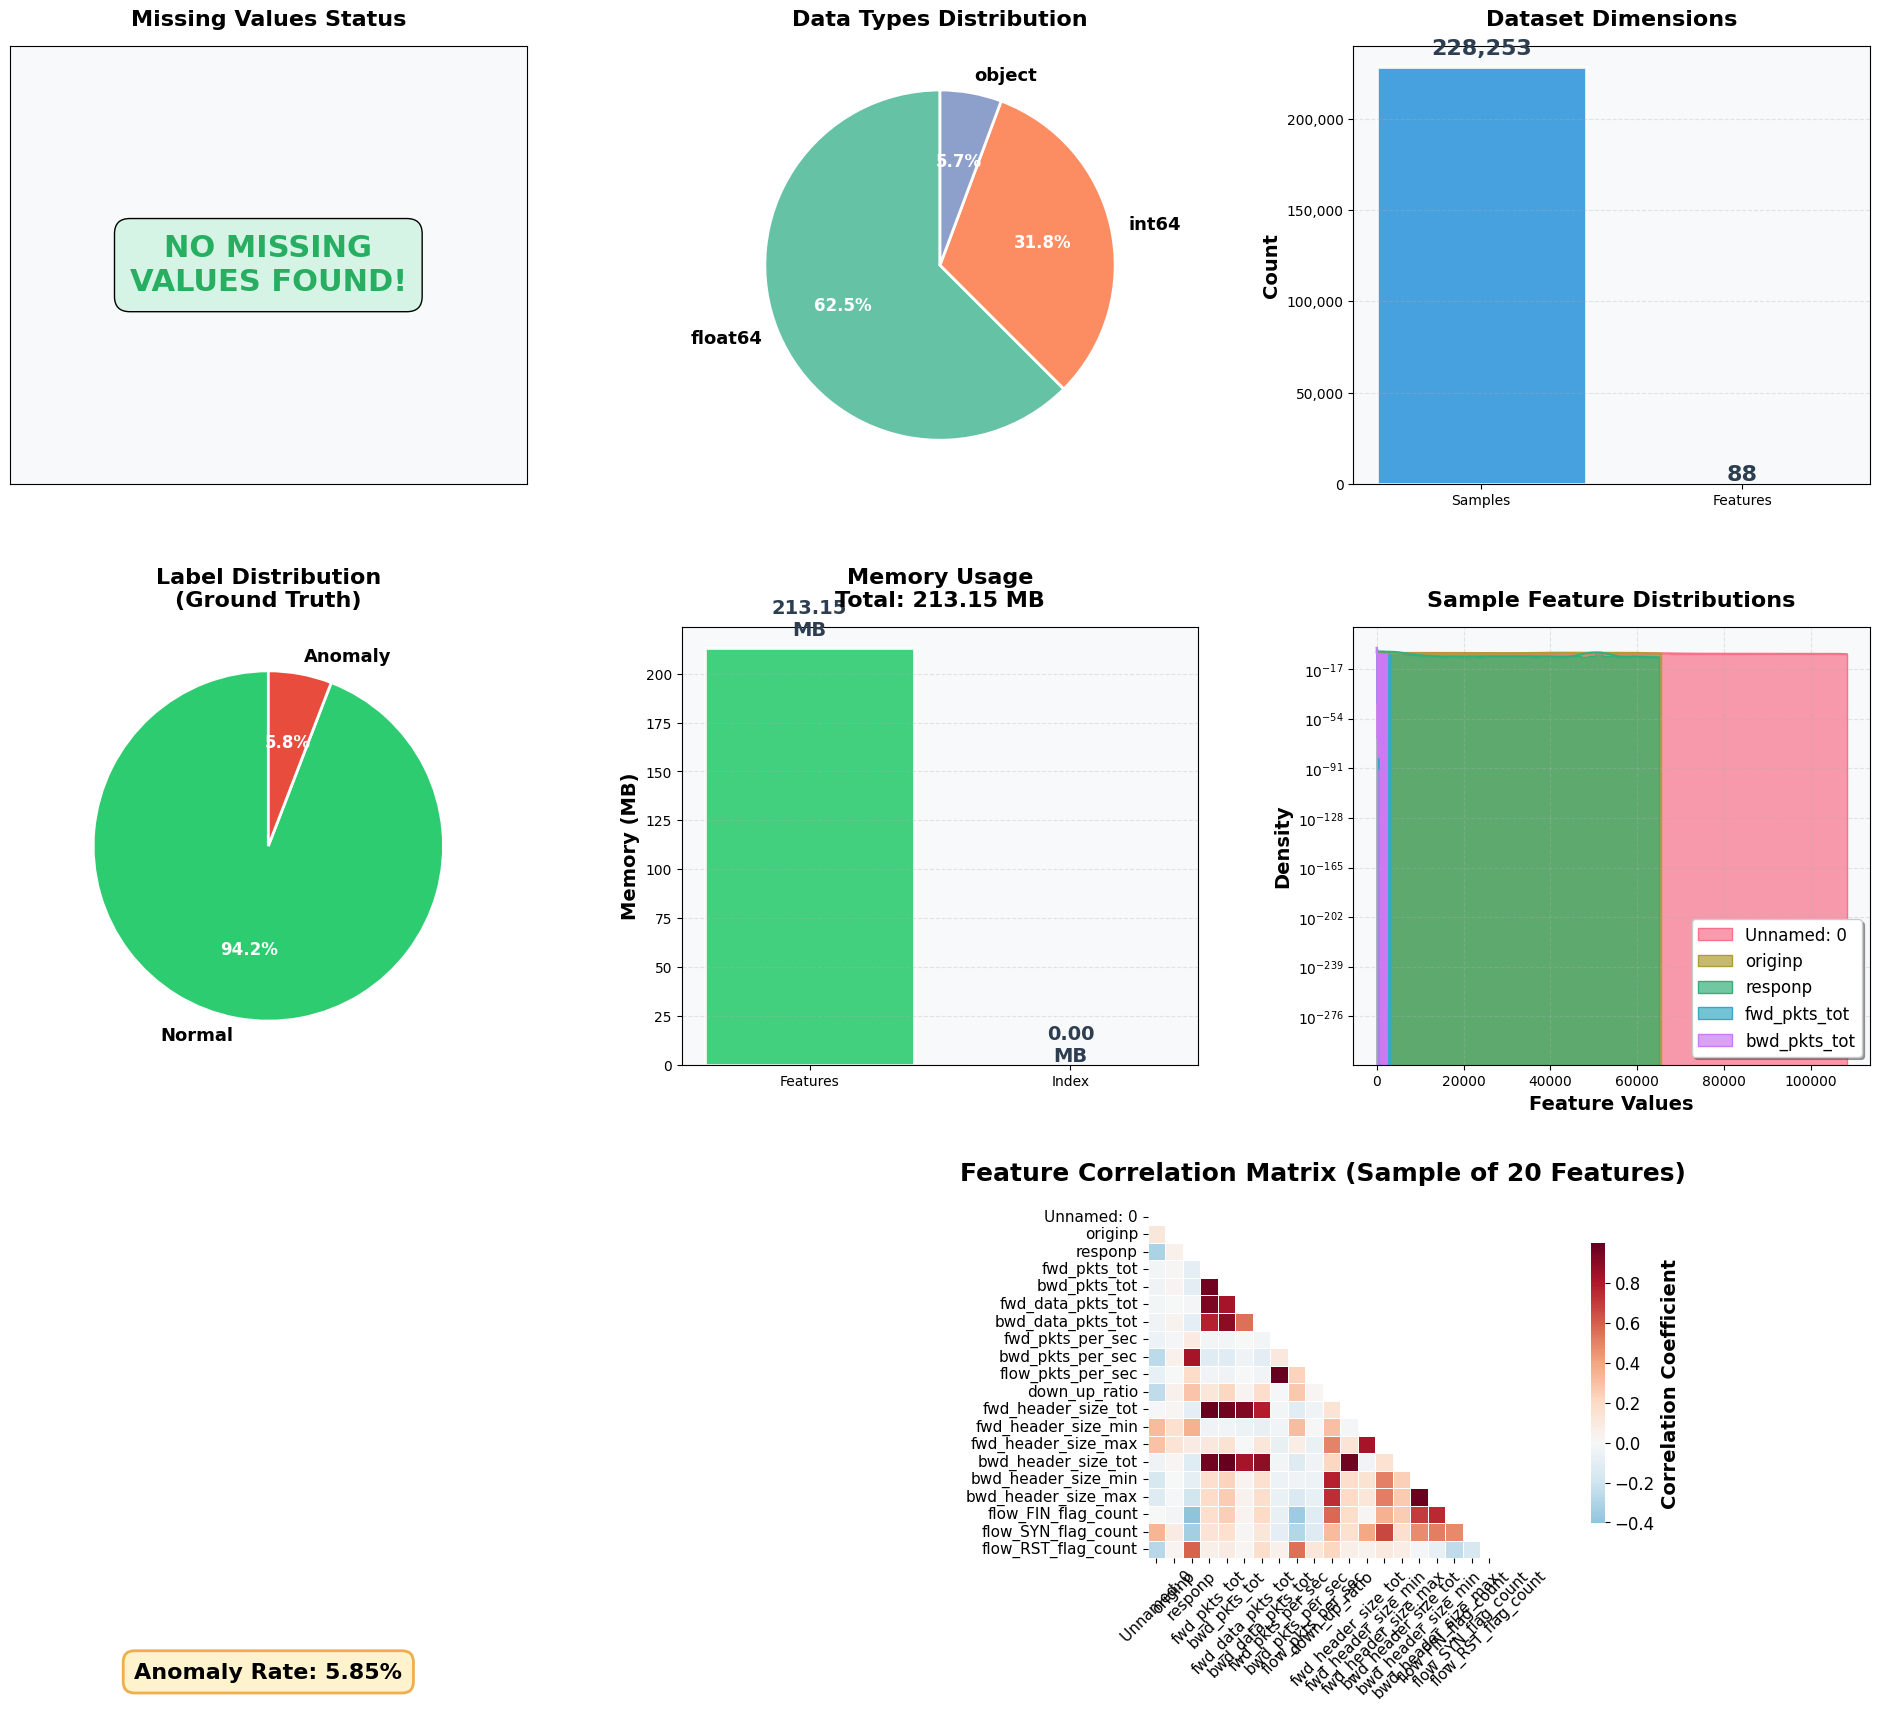


COMPREHENSIVE DATASET STATISTICS SUMMARY:
   Total samples: 228,253
   Total features: 88
   Memory usage: 213.15 MB
   Numerical features: 83
   Object features: 5
   Normal samples: 214,904 (94.15%)
   Anomaly samples: 13,349 (5.85%)
   Class balance ratio: 16.1:1


In [4]:
# =============================================================================
# SECTION 2: DATASET VISUALIZATION OVERVIEW
# =============================================================================

def create_comprehensive_dataset_visualizations(df):

    print("\nSTEP 2: COMPREHENSIVE DATASET VISUALIZATIONS")
    print("=" * 75)

    # Set modern style
    plt.style.use('default')
    sns.set_palette("husl")

    # figure size for better readability
    fig = plt.figure(figsize=(24, 18))
    #fig.suptitle('Comprehensive Dataset Overview for Anomaly Detection',
    #             fontsize=26, fontweight='bold', y=0.95, color='#2C3E50')

    # Enhanced grid layout with better spacing
    gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 0.8], width_ratios=[1, 1, 1],
                         hspace=0.35, wspace=0.3)

    # Define safe, validated colors
    primary_colors = ['#3498DB', '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6', '#1ABC9C']

    def get_safe_color(color_index, fallback='#3498DB'):

        try:
            if color_index < len(primary_colors):
                color = primary_colors[color_index]
                return color if is_color_like(color) else fallback
            return fallback
        except:
            return fallback

    # Missing Values Analysis
    ax1 = fig.add_subplot(gs[0, 0])
    missing_data = df.isnull().sum()
    if missing_data.sum() > 0:
        missing_features = missing_data[missing_data > 0].sort_values(ascending=True)
        bars = ax1.barh(range(len(missing_features)), missing_features.values,
                       color=get_safe_color(0), alpha=0.8, edgecolor='white', linewidth=1)
        ax1.set_yticks(range(len(missing_features)))
        ax1.set_yticklabels(missing_features.index, fontsize=12)
        ax1.set_title('Missing Values by Feature', fontweight='bold', fontsize=16, pad=15)
        ax1.set_xlabel('Missing Count', fontsize=14, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3, linestyle='--')
        ax1.set_facecolor('#F8F9FA')

        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax1.text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                    f'{int(width)}', ha='left', va='center', fontweight='bold')
    else:
        ax1.text(0.5, 0.5, 'NO MISSING\nVALUES FOUND!',
                horizontalalignment='center', verticalalignment='center',
                transform=ax1.transAxes, fontsize=22, fontweight='bold',
                color='#27AE60', bbox=dict(boxstyle="round,pad=0.5", facecolor="#D5F4E6"))
        ax1.set_title('Missing Values Status', fontweight='bold', fontsize=16, pad=15)
        ax1.set_facecolor('#F8F9FA')
        ax1.set_xticks([])
        ax1.set_yticks([])

    # Data Types Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    dtype_counts = df.dtypes.value_counts()
    colors = sns.color_palette("Set2", len(dtype_counts))
    wedges, texts, autotexts = ax2.pie(dtype_counts.values, labels=dtype_counts.index,
                                       autopct='%1.1f%%', colors=colors, startangle=90,
                                       textprops={'fontsize': 13, 'fontweight': 'bold'},
                                       wedgeprops={'edgecolor': 'white', 'linewidth': 2})
    ax2.set_title('Data Types Distribution', fontweight='bold', fontsize=16, pad=15)

    # Enhanced percentage text
    for autotext in autotexts:
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)
        autotext.set_color('white')

    # Dataset Dimensions - FIXED COLOR HANDLING
    ax3 = fig.add_subplot(gs[0, 2])
    dimensions = ['Samples', 'Features']
    dim_values = [df.shape[0], df.shape[1]]

    # Safe color assignment
    bar_colors = [get_safe_color(0), get_safe_color(1)]
    bars = ax3.bar(dimensions, dim_values,
                   color=bar_colors,
                   edgecolor='white', linewidth=2, alpha=0.9)
    ax3.set_title('Dataset Dimensions', fontweight='bold', fontsize=16, pad=15)
    ax3.set_ylabel('Count', fontsize=14, fontweight='bold')
    ax3.set_facecolor('#F8F9FA')
    ax3.grid(axis='y', alpha=0.3, linestyle='--')

    # Enhanced value labels with formatting
    for bar, value in zip(bars, dim_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                f'{value:,}', ha='center', va='bottom',
                fontweight='bold', fontsize=16, color='#2C3E50')

    # Format y-axis with commas
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

    # Label Distribution
    ax4 = fig.add_subplot(gs[1, 0])
    if 'Label' in df.columns:
        label_counts = df['Label'].value_counts().sort_index()
        labels = ['Normal', 'Anomaly'] if len(label_counts) == 2 else [f'Class {i}' for i in label_counts.index]
        colors_labels = ['#2ECC71', '#E74C3C'] if len(label_counts) == 2 else sns.color_palette("Set1", len(label_counts))

        wedges, texts, autotexts = ax4.pie(label_counts.values, labels=labels,
                                          autopct='%1.1f%%', colors=colors_labels,
                                          startangle=90, textprops={'fontsize': 13, 'fontweight': 'bold'},
                                          wedgeprops={'edgecolor': 'white', 'linewidth': 2})
        ax4.set_title('Label Distribution\n(Ground Truth)', fontweight='bold', fontsize=16, pad=15)

        # Enhanced anomaly rate display
        if len(label_counts) == 2:
            anomaly_rate = (label_counts[1] / len(df)) * 100
            ax4.text(0.5, -1.4, f'Anomaly Rate: {anomaly_rate:.2f}%',
                    transform=ax4.transAxes, ha='center', fontweight='bold', fontsize=16,
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="#FFF3CD",
                             edgecolor="#F0AD4E", linewidth=2))

        for autotext in autotexts:
            autotext.set_fontweight('bold')
            autotext.set_fontsize(12)
            autotext.set_color('white')
    else:
        ax4.text(0.5, 0.5, 'No Labels\nAvailable',
                ha='center', va='center', transform=ax4.transAxes,
                fontsize=20, fontweight='bold', color='#7F8C8D',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="#ECF0F1"))
        ax4.set_title('Label Information', fontweight='bold', fontsize=16, pad=15)
        ax4.set_xticks([])
        ax4.set_yticks([])

    # Memory Usage Breakdown
    ax5 = fig.add_subplot(gs[1, 1])
    memory_usage = df.memory_usage(deep=True) / 1024**2  # Convert to MB
    total_memory = memory_usage.sum()
    feature_memory = memory_usage.iloc[1:].sum()
    index_memory = memory_usage.iloc[0]

    memory_breakdown = ['Features', 'Index']
    memory_values = [feature_memory, index_memory]

    # Safe color assignment
    memory_colors = [get_safe_color(2), get_safe_color(3)]
    bars = ax5.bar(memory_breakdown, memory_values,
                   color=memory_colors,
                   edgecolor='white', linewidth=2, alpha=0.9)
    ax5.set_title(f'Memory Usage\nTotal: {total_memory:.2f} MB',
                  fontweight='bold', fontsize=16, pad=15)
    ax5.set_ylabel('Memory (MB)', fontsize=14, fontweight='bold')
    ax5.set_facecolor('#F8F9FA')
    ax5.grid(axis='y', alpha=0.3, linestyle='--')

    # Enhanced value labels
    for bar, value in zip(bars, memory_values):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                f'{value:.2f}\nMB', ha='center', va='bottom',
                fontweight='bold', fontsize=14, color='#2C3E50')

    # Sample Feature Distributions
    ax6 = fig.add_subplot(gs[1, 2])
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    if len(numerical_cols) > 0:
        sample_cols = [col for col in numerical_cols[:6] if col != 'Label'][:5]
        colors_dist = sns.color_palette("husl", len(sample_cols))

        for i, col in enumerate(sample_cols):
            try:
                sns.histplot(data=df, x=col, bins=40, kde=True, ax=ax6,
                            color=colors_dist[i], alpha=0.7, stat='density',
                            element='step', label=col)
            except:
                # Fallback to basic histogram if seaborn fails
                ax6.hist(df[col], bins=40, alpha=0.7, label=col, density=True)

        ax6.set_title('Sample Feature Distributions', fontweight='bold', fontsize=16, pad=15)
        ax6.set_xlabel('Feature Values', fontsize=14, fontweight='bold')
        ax6.set_ylabel('Density', fontsize=14, fontweight='bold')
        ax6.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
        ax6.set_yscale('log')
        ax6.set_facecolor('#F8F9FA')
        ax6.grid(alpha=0.3, linestyle='--')
    else:
        ax6.text(0.5, 0.5, 'No Numerical\nFeatures Found',
                ha='center', va='center', transform=ax6.transAxes,
                fontsize=16, fontweight='bold', color='#7F8C8D')
        ax6.set_title('Feature Distributions', fontweight='bold', fontsize=16, pad=15)

    # Feature Correlation Heatmap
    ax7 = fig.add_subplot(gs[2, :])
    if len(numerical_cols) > 1:
        sample_features = numerical_cols[:20] if len(numerical_cols) > 20 else numerical_cols
        corr_data = df[sample_features].corr()

        # Create mask for upper triangle
        mask = np.triu(np.ones_like(corr_data, dtype=bool))

        # Enhanced heatmap
        sns.heatmap(corr_data, mask=mask, annot=False, cmap='RdBu_r', center=0,
                   square=True, ax=ax7, cbar_kws={'shrink': .8, 'label': 'Correlation'},
                   linewidths=0.5, linecolor='white')

        ax7.set_title(f'Feature Correlation Matrix (Sample of {len(sample_features)} Features)',
                     fontweight='bold', fontsize=18, pad=20)
        ax7.tick_params(axis='x', rotation=45, labelsize=11)
        ax7.tick_params(axis='y', rotation=0, labelsize=11)

        # Style colorbar
        try:
            cbar = ax7.collections[0].colorbar
            cbar.ax.tick_params(labelsize=12)
            cbar.set_label('Correlation Coefficient', fontsize=14, fontweight='bold')
        except:
            pass  # Skip if colorbar styling fails
    else:
        ax7.text(0.5, 0.5, 'Insufficient Features\nfor Correlation Analysis',
                ha='center', va='center', transform=ax7.transAxes,
                fontsize=18, fontweight='bold', color='#7F8C8D')
        ax7.set_title('Feature Correlation Matrix', fontweight='bold', fontsize=18, pad=20)

    # Final layout adjustment
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

    # Enhanced statistics summary
    print(f"\nCOMPREHENSIVE DATASET STATISTICS SUMMARY:")
    print("=" * 50)
    print(f"   Total samples: {len(df):,}")
    print(f"   Total features: {df.shape[1]:,}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"   Numerical features: {len(numerical_cols):,}")
    print(f"   Object features: {len(df.select_dtypes(include=['object']).columns):,}")

    if 'Label' in df.columns:
        normal_count = (df['Label'] == 0).sum()
        anomaly_count = (df['Label'] == 1).sum()
        print(f"   Normal samples: {normal_count:,} ({normal_count/len(df)*100:.2f}%)")
        print(f"   Anomaly samples: {anomaly_count:,} ({anomaly_count/len(df)*100:.2f}%)")
        if anomaly_count > 0:
            print(f"   Class balance ratio: {normal_count/anomaly_count:.1f}:1")


# ==========================================================
# EXECUTION - VISUALIZATIONS
# ==========================================================

# Create enhanced comprehensive visualizations

create_comprehensive_dataset_visualizations(df)



# Section 3 - Data Cleaning and Preprossing

## Goal
- Drop non-essential columns
- Separate Features and Target ('Label' as target variable)
- Select Numeric Features
- Missing values handling
- Remove constant features
- Summarize findings and actions taken

In [5]:
# =============================================================================
# SECTION 3: DATA CLEANING AND PREPROCESSING
# =============================================================================

def clean_and_prepare_anomaly_data(df):
    """
    Clean and prepare data for anomaly detection algorithms
    """
    print("\nSTEP 3: DATA CLEANING AND PREPROCESSING")
    print("="*60)

    # Store original dataset information
    original_rows, original_cols = df.shape
    original_memory = df.memory_usage(deep=True).sum() / 1024**2

    print(f"ORIGINAL DATASET OVERVIEW:")
    print(f"   Shape: ({original_rows:,}, {original_cols})")
    print(f"   Memory usage: {original_memory:.2f} MB")

    # Drop specified non-essential columns
    columns_to_drop = ['Unnamed: 0', 'uid', 'originh', 'responh', 'flow_duration', 'attack_category']


    existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]

    if existing_cols_to_drop:
        df_cleaned = df.drop(columns=existing_cols_to_drop)
        print(f"   Dropped {len(existing_cols_to_drop)} columns: {existing_cols_to_drop}")
    else:
        df_cleaned = df.copy()
        print(f"   No specified columns found to drop")

    # Separate features and target


    if 'Label' in df_cleaned.columns:
        y = df_cleaned['Label'].copy()
        features_df = df_cleaned.drop(columns=['Label'])
        print(f"   Target variable 'Label' extracted ({len(y):,} samples)")
    else:
        y = None
        features_df = df_cleaned.copy()
        print(f"   No 'Label' column found - unsupervised mode")

    # Select numeric features only

    numeric_columns = features_df.select_dtypes(include=[np.number]).columns.tolist()
    X = features_df[numeric_columns].copy()

    non_numeric_cols = len(features_df.columns) - len(numeric_columns)
    print(f"   Selected {len(numeric_columns)} numeric features")
    if non_numeric_cols > 0:
        print(f"   Excluded {non_numeric_cols} non-numeric columns")

    # Handle missing values

    rows_before_na = len(X)
    missing_counts = X.isnull().sum().sum()

    if missing_counts > 0:
        X = X.dropna()
        if y is not None:
            y = y.loc[X.index]
        rows_removed_na = rows_before_na - len(X)
        print(f"   Removed {rows_removed_na:,} rows with missing values")
    else:
        print(f"   No missing values found")

    # Remove constant features

    constant_features = []
    for col in X.columns:
        if X[col].nunique() <= 1:
            constant_features.append(col)

    if constant_features:
        X = X.drop(columns=constant_features)
        print(f"   Removed {len(constant_features)} constant features: {constant_features}")
    else:
        print(f"   No constant features found")

    # Final statistics
    final_rows, final_cols = X.shape
    final_memory = X.memory_usage(deep=True).sum() / 1024**2

    rows_removed = original_rows - final_rows
    cols_removed = original_cols - final_cols
    memory_saved = original_memory - final_memory

    print(f"\nFINAL DATASET STATISTICS:")
    print(f"   Original shape: ({original_rows:,}, {original_cols})")
    print(f"   Final shape: ({final_rows:,}, {final_cols})")
    print(f"   Rows removed: {rows_removed:,}")
    print(f"   Features removed: {cols_removed}")
    print(f"   Memory usage: {final_memory:.2f} MB (saved {memory_saved:.2f} MB)")

    if y is not None:
        print(f"\nTARGET VARIABLE ANALYSIS:")
        print(f"   Target shape: {y.shape}")
        value_counts = y.value_counts().sort_index()
        print(f"   Class distribution:")
        for class_val, count in value_counts.items():
            percentage = (count / len(y)) * 100
            print(f"      Class {class_val}: {count:,} samples ({percentage:.2f}%)")

    return X, y


# ==========================================================
# EXECUTION
# ==========================================================

# Clean and prepare data for anomaly detection
X, y = clean_and_prepare_anomaly_data(df)



STEP 3: DATA CLEANING AND PREPROCESSING
ORIGINAL DATASET OVERVIEW:
   Shape: (228,253, 88)
   Memory usage: 213.15 MB
   Dropped 6 columns: ['Unnamed: 0', 'uid', 'originh', 'responh', 'flow_duration', 'attack_category']
   Target variable 'Label' extracted (228,253 samples)
   Selected 81 numeric features
   No missing values found
   Removed 2 constant features: ['fwd_URG_flag_count', 'bwd_URG_flag_count']

FINAL DATASET STATISTICS:
   Original shape: (228,253, 88)
   Final shape: (228,253, 79)
   Rows removed: 0
   Features removed: 9
   Memory usage: 137.57 MB (saved 75.58 MB)

TARGET VARIABLE ANALYSIS:
   Target shape: (228253,)
   Class distribution:
      Class 0: 214,904 samples (94.15%)
      Class 1: 13,349 samples (5.85%)


# Section 4 - Split dataset in Training and Testing (80:20)

## Goal
- Set split
    | Dataset | % Split |
    |----------|-------|
    | Training | 80% |
    | Testing | 20% |
- Show split results
- Show statistics
- Evaluate Anomaly Rates per split
- Summarize findings and actions taken


STEP 5: TRAIN-TEST SPLIT FOR ANOMALY DETECTION
SPLIT CONFIGURATION:
-------------------------
   Train size: 80%
   Test size: 20%
   Random state: 42

SPLIT RESULTS:
--------------------
   X_train shape: (182602, 79)
   X_test shape: (45651, 79)
     y_train shape: (182602,)
     y_test shape: (45651,)


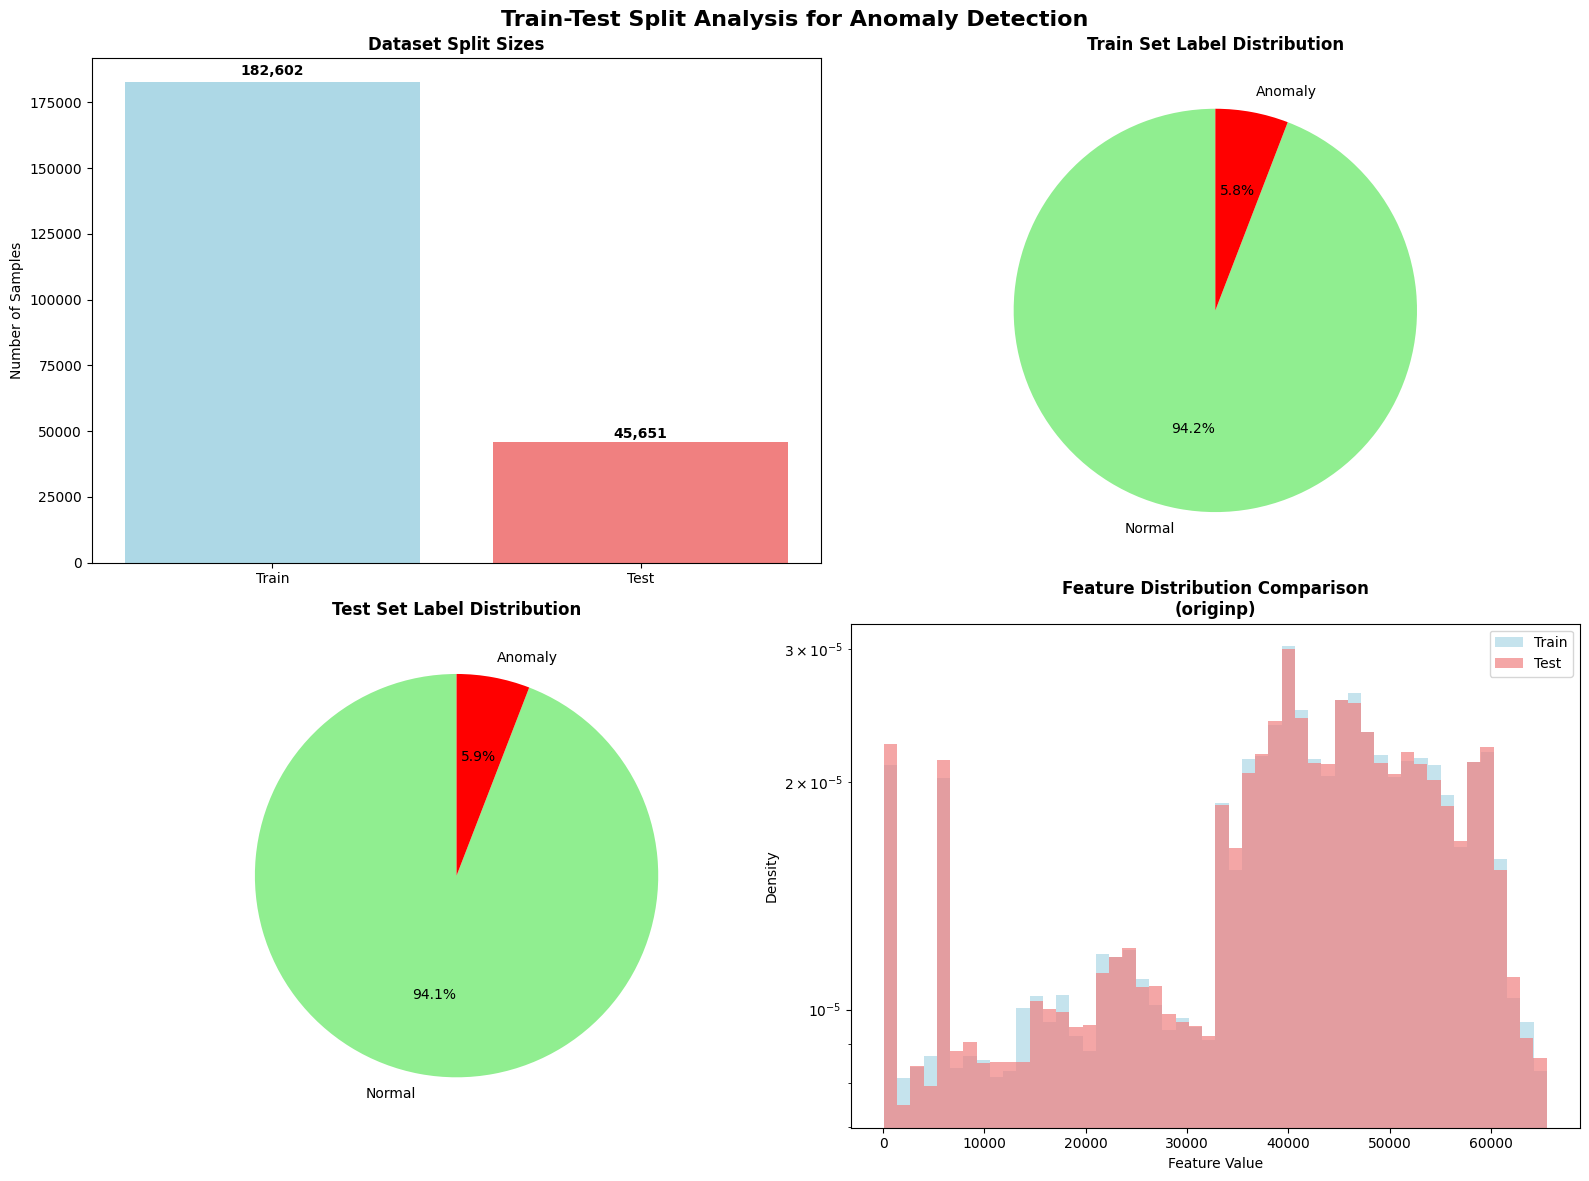


DETAILED LABEL STATISTICS:
-----------------------------------
   TRAIN SET:
     Normal (0): 171,930 (94.16%)
     Anomaly (1): 10,672 (5.84%)
   TEST SET:
     Normal (0): 42,974 (94.14%)
     Anomaly (1): 2,677 (5.86%)

ANOMALY RATES:
   Train set: 5.84%
   Test set: 5.86%

DATA SPLIT COMPLETED!
   Ready for anomaly detection training
   Train samples: 182,602
   Test samples: 45,651
    Labels available for model evaluation


In [6]:
# =============================================================================
# SECTION 4: TRAIN-TEST SPLIT FOR ANOMALY DETECTION
# =============================================================================

def split_anomaly_detection_data(X, y=None, test_size=0.2, random_state=RANDOM_SEED):
    """
    Split data for anomaly detection analysis with comprehensive visualization
    """
    print("\nSTEP 5: TRAIN-TEST SPLIT FOR ANOMALY DETECTION")
    print("=" * 55)

    print(f"SPLIT CONFIGURATION:")
    print("-" * 25)
    print(f"   Train size: {(1-test_size)*100:.0f}%")
    print(f"   Test size: {test_size*100:.0f}%")
    print(f"   Random state: {random_state}")


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)

    print(f"\nSPLIT RESULTS:")
    print("-" * 20)
    print(f"   X_train shape: {X_train.shape}")
    print(f"   X_test shape: {X_test.shape}")
    if y is not None:
        print(f"     y_train shape: {y_train.shape}")
        print(f"     y_test shape: {y_test.shape}")

    # Create visualization
    if y is not None:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Train-Test Split Analysis for Anomaly Detection',
                     fontsize=16, fontweight='bold')

        # Split sizes
        ax1 = axes[0, 0]
        split_names = ['Train', 'Test']
        split_sizes = [len(X_train), len(X_test)]
        colors = ['lightblue', 'lightcoral']
        bars = ax1.bar(split_names, split_sizes, color=colors)
        ax1.set_title('Dataset Split Sizes', fontweight='bold')
        ax1.set_ylabel('Number of Samples')

        # Add value labels
        for bar, size in zip(bars, split_sizes):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{size:,}', ha='center', va='bottom', fontweight='bold')

        # Label distribution in train set
        ax2 = axes[0, 1]
        train_unique, train_counts = np.unique(y_train, return_counts=True)
        labels_train = ['Normal', 'Anomaly'] if len(train_unique) == 2 else [f'Class {i}' for i in train_unique]
        colors_pie = ['lightgreen', 'red'] if len(train_unique) == 2 else plt.cm.Set1(np.arange(len(train_unique)))

        wedges, texts, autotexts = ax2.pie(train_counts, labels=labels_train, autopct='%1.1f%%',
                                          colors=colors_pie, startangle=90)
        ax2.set_title('Train Set Label Distribution', fontweight='bold')

        # Label distribution in test set
        ax3 = axes[1, 0]
        test_unique, test_counts = np.unique(y_test, return_counts=True)
        labels_test = ['Normal', 'Anomaly'] if len(test_unique) == 2 else [f'Class {i}' for i in test_unique]

        wedges, texts, autotexts = ax3.pie(test_counts, labels=labels_test, autopct='%1.1f%%',
                                          colors=colors_pie, startangle=90)
        ax3.set_title('Test Set Label Distribution', fontweight='bold')

        # Feature distribution comparison (sample feature)
        ax4 = axes[1, 1]
        # Take first numerical feature for comparison
        feature_col = X_train.columns[0]
        ax4.hist(X_train[feature_col], bins=50, alpha=0.7, label='Train', color='lightblue', density=True)
        ax4.hist(X_test[feature_col], bins=50, alpha=0.7, label='Test', color='lightcoral', density=True)
        ax4.set_title(f'Feature Distribution Comparison\n({feature_col})', fontweight='bold')
        ax4.set_xlabel('Feature Value')
        ax4.set_ylabel('Density')
        ax4.legend()
        ax4.set_yscale('log')

        plt.tight_layout()
        plt.show()

        # Detailed label statistics
        print(f"\nDETAILED LABEL STATISTICS:")
        print("-" * 35)
        print(f"   TRAIN SET:")
        for label, count in zip(train_unique, train_counts):
            label_name = "Normal" if label == 0 else "Anomaly"
            print(f"     {label_name} ({label}): {count:,} ({count/len(y_train)*100:.2f}%)")

        print(f"   TEST SET:")
        for label, count in zip(test_unique, test_counts):
            label_name = "Normal" if label == 0 else "Anomaly"
            print(f"     {label_name} ({label}): {count:,} ({count/len(y_test)*100:.2f}%)")

        # Anomaly rates
        train_anomaly_rate = (y_train == 1).sum() / len(y_train) * 100
        test_anomaly_rate = (y_test == 1).sum() / len(y_test) * 100
        print(f"\nANOMALY RATES:")
        print(f"   Train set: {train_anomaly_rate:.2f}%")
        print(f"   Test set: {test_anomaly_rate:.2f}%")
    else:
        # Simple visualization without labels
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        split_names = ['Train', 'Test']
        split_sizes = [len(X_train), len(X_test)]
        colors = ['lightblue', 'lightcoral']
        bars = ax.bar(split_names, split_sizes, color=colors)
        ax.set_title('Dataset Split Sizes', fontweight='bold')
        ax.set_ylabel('Number of Samples')

        for bar, size in zip(bars, split_sizes):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{size:,}', ha='center', va='bottom', fontweight='bold')
        plt.show()

    print(f"\nDATA SPLIT COMPLETED!")
    print(f"   Ready for anomaly detection training")
    print(f"   Train samples: {len(X_train):,}")
    print(f"   Test samples: {len(X_test):,}")
    if y is not None:
        print(f"    Labels available for model evaluation")

    return X_train, X_test, y_train, y_test

# ==========================================================
# EXECUTION
# ==========================================================

# Split data for anomaly detection
X_train, X_test, y_train, y_test = split_anomaly_detection_data(X, y)


# Section 5 - Implement the Anomaly Detection Algorithms

## Goal
- Implement the following Anomaly Detection Algorithms:

| Algorithm            | Description                                                            | Type                             |
|----------------------|------------------------------------------------------------------------|----------------------------------|
| Isolation Forest     | Randomly isolates points; anomalies require **fewer splits**.          | Unsupervised anomaly detection   |
| Local Outlier Factor | Flags points with **lower local density** than their neighbors.        | Density-based outlier detection  |
| One-Class SVM        | Learns a boundary around **normal data**; outside points are outliers. | Unsupervised novelty detection   |
| DBSCAN               | Forms clusters from **dense regions**; sparse points become noise.     | Density-based clustering         |
| Elliptic Envelope    | Fits a **robust covariance ellipse**; outside points are outliers.     | Covariance-based outlier detection |

- Try different hyperparameters and choose the best
- Summarize findings and actions taken

In [7]:
# =============================================================================
# SECTION 5: ANOMALY DETECTION ALGORITHMS IMPLEMENTATION (IMPROVED)
# =============================================================================

import numpy as np
from sklearn.metrics import silhouette_score

# Define contamination scenarios to test
CONTAMINATION_SCENARIOS = [0.01, 0.03, 0.05, 0.1, 0.15]

def train_isolation_forest(X_train, contamination=0.05, n_estimators=500, random_state=RANDOM_SEED, use_gpu=True):
    """
    Train Isolation Forest for anomaly detection with comprehensive output
    """
    print(f"   Training Isolation Forest (contamination={contamination})")

    if use_gpu and CUML_AVAILABLE:
        # Convert to cudf DataFrame for GPU processing
        X_train_gpu = cudf.DataFrame(X_train)
        model = cuIsolationForest(
            n_estimators=n_estimators,
            contamination=contamination,
            random_state=random_state
        )
        model.fit(X_train_gpu)
    else:
        model = IsolationForest(
            n_estimators=n_estimators,
            contamination=contamination,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train)

    return model


def train_isolation_forest_best(X_train, contaminations=CONTAMINATION_SCENARIOS, n_estimators=500, random_state=RANDOM_SEED, use_gpu=True):
    """
    Train Isolation Forest with multiple contamination scenarios and select the best
    """
    print("\nTRAINING ISOLATION FOREST WITH MULTIPLE CONTAMINATION SCENARIOS")
    print("=" * 65)

    print(f"MODEL CONFIGURATION:")
    print(f"   Algorithm: Isolation Forest")
    print(f"   N Estimators: {n_estimators}")
    print(f"   Contamination scenarios: {contaminations}")
    print(f"   Random State: {random_state}")
    print(f"   Using {'GPU (CUML)' if use_gpu and CUML_AVAILABLE else 'CPU (Scikit-learn)'}")

    best_model = None
    best_contamination = None
    best_score = float('inf')
    evaluation_results = []

    for contamination in contaminations:
        model = train_isolation_forest(X_train, contamination, n_estimators, random_state, use_gpu)

        # Evaluate using average anomaly score (lower is better for normal data)
        if use_gpu and CUML_AVAILABLE:
            scores = model.decision_function(cudf.DataFrame(X_train))
            avg_score = np.mean(scores.to_array())
        else:
            scores = model.decision_function(X_train)
            avg_score = np.mean(scores)

        evaluation_results.append((contamination, avg_score))

        if avg_score < best_score:
            best_score = avg_score
            best_model = model
            best_contamination = contamination

        print(f"   Contamination {contamination}: Average anomaly score = {avg_score:.6f}")

    print(f"\n   BEST CONFIGURATION:")
    print(f"   Best contamination: {best_contamination}")
    print(f"   Best average score: {best_score:.6f}")
    print(f"   Isolation Forest training completed with optimal parameters!")

    return best_model


def train_local_outlier_factor(X_train, n_neighbors=20, contamination=0.05, use_gpu=True):
    """
    Train Local Outlier Factor for anomaly detection
    """
    print(f"   Training LOF (contamination={contamination})")

    model = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=contamination,
        n_jobs=-1
    )

    anomaly_labels = model.fit_predict(X_train)
    return model, anomaly_labels


def train_local_outlier_factor_best(X_train, n_neighbors=20, contaminations=CONTAMINATION_SCENARIOS, use_gpu=True):
    """
    Train Local Outlier Factor with multiple contamination scenarios and select the best
    """
    print("\nTRAINING LOCAL OUTLIER FACTOR (LOF) WITH MULTIPLE CONTAMINATION SCENARIOS")
    print("=" * 70)

    print(f"MODEL CONFIGURATION:")
    print(f"   Algorithm: Local Outlier Factor")
    print(f"   N Neighbors: {n_neighbors}")
    print(f"   Contamination scenarios: {contaminations}")
    print(f"   Using CPU processing (Scikit-learn)")

    best_model = None
    best_contamination = None
    best_score = -float('inf')
    best_labels = None
    evaluation_results = []

    for contamination in contaminations:
        model, labels = train_local_outlier_factor(X_train, n_neighbors, contamination, use_gpu)

        # Evaluate using silhouette score (higher is better)
        try:
            if len(set(labels)) > 1:  # Need at least 2 different labels
                score = silhouette_score(X_train, labels)
            else:
                score = -1  # Poor score if all points have same label
        except:
            score = -1

        evaluation_results.append((contamination, score))

        if score > best_score:
            best_score = score
            best_model = model
            best_contamination = contamination
            best_labels = labels

        print(f"   Contamination {contamination}: Silhouette score = {score:.6f}")

    print(f"\n   BEST CONFIGURATION:")
    print(f"   Best contamination: {best_contamination}")
    print(f"   Best silhouette score: {best_score:.6f}")
    print(f"   LOF training completed with optimal parameters!")

    return best_model, best_labels


def train_one_class_svm(X_train, kernel='rbf', gamma='scale', nu=0.05):
    """
    Train One-Class SVM for anomaly detection
    """
    print(f"   Training One-Class SVM (nu={nu})")

    model = OneClassSVM(
        kernel=kernel,
        gamma=gamma,
        nu=nu
    )

    model.fit(X_train)
    return model


def train_one_class_svm_best(X_train, kernel='rbf', gamma='scale', nus=CONTAMINATION_SCENARIOS):
    """
    Train One-Class SVM with multiple nu scenarios and select the best
    """
    print("\nTRAINING ONE-CLASS SVM WITH MULTIPLE NU SCENARIOS")
    print("=" * 50)

    print(f"MODEL CONFIGURATION:")
    print(f"   Algorithm: One-Class SVM")
    print(f"   Kernel: {kernel}")
    print(f"   Gamma: {gamma}")
    print(f"   Nu scenarios: {nus}")

    best_model = None
    best_nu = None
    best_score = -float('inf')
    evaluation_results = []

    for nu in nus:
        model = train_one_class_svm(X_train, kernel, gamma, nu)

        # Evaluate using average score (higher is better for inliers)
        try:
            scores = model.score_samples(X_train)
            avg_score = np.mean(scores)
        except:
            avg_score = -float('inf')

        evaluation_results.append((nu, avg_score))

        if avg_score > best_score:
            best_score = avg_score
            best_model = model
            best_nu = nu

        print(f"   Nu {nu}: Average score = {avg_score:.6f}")

    print(f"\n   BEST CONFIGURATION:")
    print(f"   Best nu: {best_nu}")
    print(f"   Best average score: {best_score:.6f}")
    print(f"   One-Class SVM training completed with optimal parameters!")

    return best_model


def train_dbscan_anomaly(X_train, eps=0.5, min_samples=5):
    """
    Train DBSCAN for anomaly detection (noise points are anomalies)
    """
    print("\nTRAINING DBSCAN FOR ANOMALY DETECTION")
    print("=" * 45)

    print(f"MODEL CONFIGURATION:")
    print(f"   Algorithm: DBSCAN (noise as anomalies)")
    print(f"   Eps (neighborhood distance): {eps}")
    print(f"   Min Samples: {min_samples}")

    model = DBSCAN(
        eps=eps,
        min_samples=min_samples,
        n_jobs=-1
    )

    print(f"   Training DBSCAN with {len(X_train):,} samples...")
    cluster_labels = model.fit_predict(X_train)

    # Count clusters and noise points
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)

    print(f"   Clustering results:")
    print(f"     Number of clusters: {n_clusters}")
    print(f"     Noise points (anomalies): {n_noise:,} ({n_noise/len(X_train)*100:.2f}%)")
    print(f"     DBSCAN training completed!")

    return model, cluster_labels


def train_elliptic_envelope(X_train, contamination=0.05, random_state=RANDOM_SEED):
    """
    Train Elliptic Envelope for anomaly detection
    """
    print(f"   Training Elliptic Envelope (contamination={contamination})")

    model = EllipticEnvelope(
        contamination=contamination,
        random_state=random_state
    )

    model.fit(X_train)
    return model


def train_elliptic_envelope_best(X_train, contaminations=CONTAMINATION_SCENARIOS, random_state=RANDOM_SEED):
    """
    Train Elliptic Envelope with multiple contamination scenarios and select the best
    """
    print("\nTRAINING ELLIPTIC ENVELOPE WITH MULTIPLE CONTAMINATION SCENARIOS")
    print("=" * 65)

    print(f"MODEL CONFIGURATION:")
    print(f"   Algorithm: Elliptic Envelope (Robust Covariance)")
    print(f"   Contamination scenarios: {contaminations}")
    print(f"   Random State: {random_state}")

    best_model = None
    best_contamination = None
    best_score = -float('inf')
    evaluation_results = []

    for contamination in contaminations:
        model = train_elliptic_envelope(X_train, contamination, random_state)

        # Evaluate using average log-likelihood (higher is better)
        try:
            scores = model.score_samples(X_train)
            avg_score = np.mean(scores)
        except:
            avg_score = -float('inf')

        evaluation_results.append((contamination, avg_score))

        if avg_score > best_score:
            best_score = avg_score
            best_model = model
            best_contamination = contamination

        print(f"   Contamination {contamination}: Average log-likelihood = {avg_score:.6f}")

    print(f"\n   BEST CONFIGURATION:")
    print(f"   Best contamination: {best_contamination}")
    print(f"   Best average log-likelihood: {best_score:.6f}")
    print(f"   Elliptic Envelope training completed with optimal parameters!")

    return best_model


# ==========================================================
# EXECUTION - TRAIN ALL ANOMALY DETECTION MODELS WITH OPTIMAL PARAMETERS
# ==========================================================

print("\nSTEP 6: TRAINING ANOMALY DETECTION ALGORITHMS WITH PARAMETER OPTIMIZATION")
print("=" * 80)
print("All models will be trained with multiple parameter scenarios")
print("Best performing models will be selected based on internal evaluation metrics")
print("Models will identify anomalies in an unsupervised manner")

# Dictionary to store all trained models
anomaly_models = {}

# Isolation Forest with contamination optimization
try:
    print(f"\n{'='*80}")
    isolation_forest = train_isolation_forest_best(X_train, CONTAMINATION_SCENARIOS, n_estimators=500, random_state=RANDOM_SEED)
    anomaly_models['Isolation Forest'] = isolation_forest
    print(f"✓ Isolation Forest successfully trained with optimal contamination")
except Exception as e:
    print(f"✗ Isolation Forest training failed: {str(e)}")

# Local Outlier Factor with contamination optimization
try:
    print(f"\n{'='*80}")
    lof_model, lof_train_labels = train_local_outlier_factor_best(X_train, n_neighbors=20, contaminations=CONTAMINATION_SCENARIOS)
    anomaly_models['Local Outlier Factor'] = lof_model
    print(f"✓ Local Outlier Factor successfully trained with optimal contamination")
except Exception as e:
    print(f"✗ Local Outlier Factor training failed: {str(e)}")

# One-Class SVM with nu optimization
try:
    print(f"\n{'='*80}")
    oneclass_svm = train_one_class_svm_best(X_train, nus=CONTAMINATION_SCENARIOS)
    anomaly_models['One-Class SVM'] = oneclass_svm
    print(f"✓ One-Class SVM successfully trained with optimal nu")
except Exception as e:
    print(f"✗ One-Class SVM training failed: {str(e)}")

# DBSCAN (no contamination parameter, keeps original implementation)
try:
    print(f"\n{'='*80}")
    dbscan_model, dbscan_train_labels = train_dbscan_anomaly(X_train, eps=1.0, min_samples=10)
    anomaly_models['DBSCAN'] = dbscan_model
    print(f"✓ DBSCAN successfully trained")
except Exception as e:
    print(f"✗ DBSCAN training failed: {str(e)}")

# Elliptic Envelope with contamination optimization
try:
    print(f"\n{'='*80}")
    elliptic_envelope = train_elliptic_envelope_best(X_train, CONTAMINATION_SCENARIOS, random_state=RANDOM_SEED)
    anomaly_models['Elliptic Envelope'] = elliptic_envelope
    print(f"✓ Elliptic Envelope successfully trained with optimal contamination")
except Exception as e:
    print(f"✗ Elliptic Envelope training failed: {str(e)}")

print(f"\nANOMALY DETECTION TRAINING SUMMARY WITH PARAMETER OPTIMIZATION")
print("=" * 70)
print(f"   Successfully trained models: {len(anomaly_models)}")
print(f"   Available models: {list(anomaly_models.keys())}")
print(f"   Training dataset size: {len(X_train):,} samples")
print(f"   Features used: {X_train.shape[1]}")
print(f"   Contamination scenarios tested: {CONTAMINATION_SCENARIOS}")
print(f"   Each model was optimized using internal evaluation metrics")



STEP 6: TRAINING ANOMALY DETECTION ALGORITHMS WITH PARAMETER OPTIMIZATION
All models will be trained with multiple parameter scenarios
Best performing models will be selected based on internal evaluation metrics
Models will identify anomalies in an unsupervised manner


TRAINING ISOLATION FOREST WITH MULTIPLE CONTAMINATION SCENARIOS
MODEL CONFIGURATION:
   Algorithm: Isolation Forest
   N Estimators: 500
   Contamination scenarios: [0.01, 0.03, 0.05, 0.1, 0.15]
   Random State: 42
   Using CPU (Scikit-learn)
   Training Isolation Forest (contamination=0.01)
   Contamination 0.01: Average anomaly score = 0.268184
   Training Isolation Forest (contamination=0.03)
   Contamination 0.03: Average anomaly score = 0.196021
   Training Isolation Forest (contamination=0.05)
   Contamination 0.05: Average anomaly score = 0.144454
   Training Isolation Forest (contamination=0.1)
   Contamination 0.1: Average anomaly score = 0.077870
   Training Isolation Forest (contamination=0.15)
   Contaminat

# Section 6 - Implement the Anomaly Detection Algorithms - Autoencoder

## Goal
- Implement an Autoencoder Algorithm for Anomaly Detection

| Algorithm            | Description                                                            | Type                             |
|----------------------|------------------------------------------------------------------------|----------------------------------|
| Autoenconder     | Trains a neural network to reconstruct normal data and then treats samples with large reconstruction error as anomalies.        | Unsupervised anomaly detection   |


- Summarize findings and actions taken


ANOMALY DETECTION WITH AUTOENCODER
='*70}
PREPARING DATA FOR ANOMALY DETECTION...
Strategy: Train on normal data, detect anomalies via reconstruction error

DATA SPLIT FOR ANOMALY DETECTION:
   Original training samples: 182,602
   Normal samples (for training): 171,930
   Anomaly samples (excluded from training): 10,672
   Test samples (to be classified): 45,651

TRAINING AUTOENCODER FOR ANOMALY DETECTION
TRAINING STRATEGY: NORMAL DATA ONLY
   - Train autoencoder only on normal samples (label 0)
   - Model learns to reconstruct normal patterns accurately
   - Anomalies (label 1) will have high reconstruction error
   - Threshold reconstruction error to classify anomalies

TRAINING CONFIGURATION:
   Model: Autoencoder Neural Network
   Training data: NORMAL SAMPLES ONLY
   Encoding dims: [128, 64, 32]
   Dropout: 0.2
   Learning rate: 0.001
   Epochs: 500
   Batch size: 512
   Device: cpu
   Early stopping patience: 10
   Early stopping delta: 0.0001

DATA PREPARATION FOR ANOMALY DETE

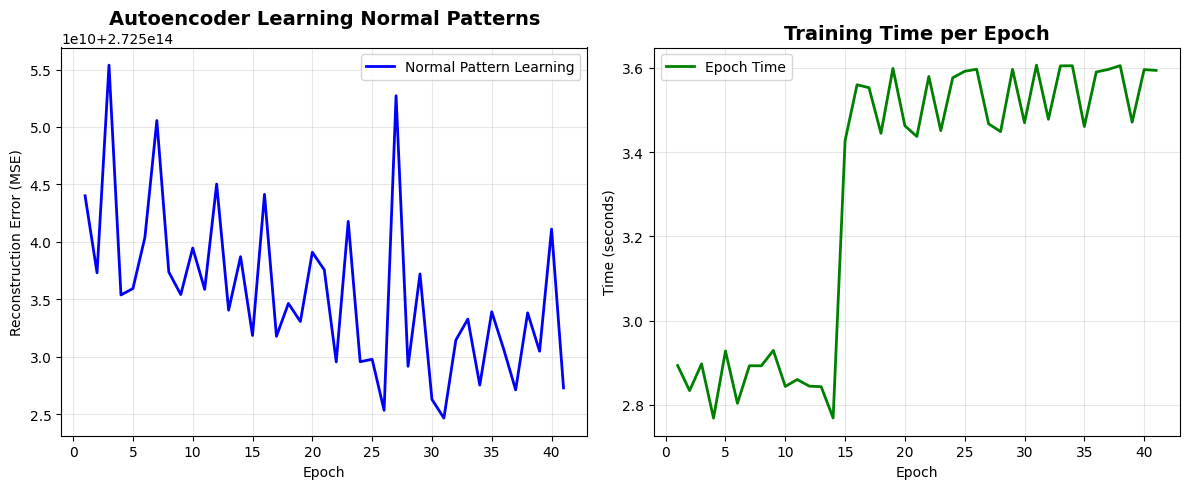

Autoencoder successfully trained for anomaly detection

TESTING ANOMALY DETECTION PERFORMANCE:

TESTING THRESHOLD: 95th PERCENTILE

ANOMALY DETECTION USING RECONSTRUCTION ERROR
DETECTION STRATEGY:
   - Normal samples: Low reconstruction error
   - Anomaly samples: High reconstruction error
   - Threshold: Based on reconstruction error percentile

ANALYZING RECONSTRUCTION ERRORS FOR ANOMALY DETECTION:
   90.0th percentile: threshold=1772349161472.000000, anomalies=4,565 (10.00%)
   95.0th percentile: threshold=39477095432192.000000, anomalies=2,283 (5.00%)
   97.0th percentile: threshold=231774957338624.000000, anomalies=1,370 (3.00%)
   98.0th percentile: threshold=473105478713344.000000, anomalies=913 (2.00%)
   99.0th percentile: threshold=546900365279232.000000, anomalies=457 (1.00%)
   99.5th percentile: threshold=1236059509751808.000000, anomalies=227 (0.50%)

ANOMALY DETECTION RESULTS (95th percentile):
   Reconstruction error statistics:
     Min error: 2482376.500000
     Max e

In [ ]:
# =============================================================================
# SECTION 6: PYTORCH AUTOENCODER FOR ANOMALY DETECTION
# =============================================================================

import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def create_autoencoder_model(input_dim, encoding_dims=[64, 32, 16], dropout=0.2):
    """
    Create autoencoder model for anomaly detection using PyTorch
    Architecture designed to learn normal patterns and detect anomalies via reconstruction error
    """
    print(f"AUTOENCODER ARCHITECTURE FOR ANOMALY DETECTION:")
    print("-" * 50)
    print(f"   Input dimension: {input_dim}")
    print(f"   Encoding layers: {len(encoding_dims)}")
    print(f"   Encoding dimensions: {encoding_dims}")
    print(f"   Dropout rate: {dropout}")
    print(f"   Purpose: Learn normal patterns, detect anomalies via reconstruction error")

    # Build encoder with batch normalization
    encoder_layers = []
    prev_dim = input_dim

    for i, encoding_dim in enumerate(encoding_dims):
        encoder_layers.append(nn.Linear(prev_dim, encoding_dim))
        encoder_layers.append(nn.BatchNorm1d(encoding_dim))
        encoder_layers.append(nn.ReLU())
        if i < len(encoding_dims) - 1:  # No dropout in bottleneck layer
            encoder_layers.append(nn.Dropout(dropout))
        print(f"   Encoder Layer {i+1}: {prev_dim} -> {encoding_dim}")
        prev_dim = encoding_dim

    encoder = nn.Sequential(*encoder_layers)

    # Build decoder (mirror of encoder)
    decoder_layers = []
    decoding_dims = list(reversed(encoding_dims[:-1])) + [input_dim]
    prev_dim = encoding_dims[-1]  # Start from the bottleneck

    for i, decoding_dim in enumerate(decoding_dims):
        decoder_layers.append(nn.Linear(prev_dim, decoding_dim))
        if i < len(decoding_dims) - 1:  # No activation on final layer
            decoder_layers.append(nn.BatchNorm1d(decoding_dim))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(dropout))
        print(f"   Decoder Layer {i+1}: {prev_dim} -> {decoding_dim}")
        prev_dim = decoding_dim

    decoder = nn.Sequential(*decoder_layers)

    # Complete autoencoder
    autoencoder = nn.Sequential(encoder, decoder)

    # Count parameters
    total_params = sum(p.numel() for p in autoencoder.parameters())
    trainable_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)

    print(f"\nNETWORK STATISTICS:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Compression ratio: {input_dim / encoding_dims[-1]:.1f}:1")
    print(f"   Anomaly detection strategy: High reconstruction error = Anomaly")

    return autoencoder


def train_autoencoder_anomaly_detection(X_train_normal, encoding_dims=[64, 32, 16], dropout=0.2,
                                      learning_rate=0.001, epochs=100, batch_size=256,
                                      early_stopping_patience=10, early_stopping_delta=0.0001):
    """
    Train autoencoder ONLY on normal data for anomaly detection
    The model learns to reconstruct normal patterns with low error
    Anomalies will have high reconstruction error during inference
    """
    print("\nTRAINING AUTOENCODER FOR ANOMALY DETECTION")
    print("=" * 60)
    print("TRAINING STRATEGY: NORMAL DATA ONLY")
    print("   - Train autoencoder only on normal samples (label 0)")
    print("   - Model learns to reconstruct normal patterns accurately")
    print("   - Anomalies (label 1) will have high reconstruction error")
    print("   - Threshold reconstruction error to classify anomalies")

    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"\nTRAINING CONFIGURATION:")
    print(f"   Model: Autoencoder Neural Network")
    print(f"   Training data: NORMAL SAMPLES ONLY")
    print(f"   Encoding dims: {encoding_dims}")
    print(f"   Dropout: {dropout}")
    print(f"   Learning rate: {learning_rate}")
    print(f"   Epochs: {epochs}")
    print(f"   Batch size: {batch_size}")
    print(f"   Device: {device}")
    print(f"   Early stopping patience: {early_stopping_patience}")
    print(f"   Early stopping delta: {early_stopping_delta}")

    # Prepare data - CRITICAL: Use only normal data
    input_dim = X_train_normal.shape[1]

    # Handle both DataFrame and numpy array inputs
    if hasattr(X_train_normal, 'values'):
        X_tensor = torch.FloatTensor(X_train_normal.values).to(device)
    else:
        X_tensor = torch.FloatTensor(X_train_normal).to(device)

    print(f"\nDATA PREPARATION FOR ANOMALY DETECTION:")
    print(f"   Normal training samples shape: {X_train_normal.shape}")
    print(f"   Tensor shape: {X_tensor.shape}")
    print(f"   *** ANOMALY SAMPLES EXCLUDED FROM TRAINING ***")

    # Create model
    autoencoder = create_autoencoder_model(input_dim, encoding_dims, dropout).to(device)

    # Setup training
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    # Create data loader
    dataset = TensorDataset(X_tensor, X_tensor)  # Input = Target for autoencoder
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f"   Number of batches per epoch: {len(dataloader)}")

    # Training loop
    print(f"\nSTARTING NORMAL PATTERN LEARNING:")
    print("-" * 40)

    training_losses = []
    epoch_times = []
    autoencoder.train()

    # Early stopping variables
    best_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        epoch_start_time = time.time()
        epoch_loss = 0.0
        batch_count = 0

        for batch_X, batch_target in dataloader:
            optimizer.zero_grad()

            # Forward pass - learn to reconstruct normal patterns
            reconstructed = autoencoder(batch_X)
            loss = criterion(reconstructed, batch_target)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

        # Calculate average loss for this epoch
        avg_loss = epoch_loss / batch_count
        epoch_time = time.time() - epoch_start_time

        training_losses.append(avg_loss)
        epoch_times.append(epoch_time)

        # Learning rate scheduling
        scheduler.step(avg_loss)

        # Early stopping check
        if avg_loss + early_stopping_delta < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
            best_model_state = autoencoder.state_dict().copy()
        else:
            epochs_no_improve += 1

        # Print progress
        if (epoch + 1) % 20 == 0:
            print(f"   Epoch {epoch+1:3d}/{epochs} | MSE Loss: {avg_loss:.6f} | Time: {epoch_time:.2f}s")

        # Early stopping condition
        if epochs_no_improve >= early_stopping_patience:
            print(f"   Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model state
    if best_model_state is not None:
        autoencoder.load_state_dict(best_model_state)

    # Calculate training summary statistics
    total_training_time = sum(epoch_times)
    initial_loss = training_losses[0] if training_losses else 0
    final_loss = training_losses[-1] if training_losses else 0

    if initial_loss > 0:
        loss_reduction = ((initial_loss - final_loss) / initial_loss) * 100
    else:
        loss_reduction = 0.0

    print(f"\nANOMALY DETECTION MODEL TRAINING SUMMARY:")
    print(f"   Initial reconstruction loss: {initial_loss:.6f}")
    print(f"   Final reconstruction loss: {final_loss:.6f}")
    print(f"   Loss reduction: {loss_reduction:.1f}%")
    print(f"   Total training time: {total_training_time:.2f}s")
    print(f"   Average time per epoch: {total_training_time/len(training_losses):.2f}s")
    print(f"   Model ready for anomaly detection!")
    print(f"   *** Normal patterns learned - ready to detect anomalies ***")

    # Create training history plot
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(training_losses) + 1), training_losses, 'b-', linewidth=2, label='Normal Pattern Learning')
    plt.title('Autoencoder Learning Normal Patterns', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Time per epoch plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(epoch_times) + 1), epoch_times, 'g-', linewidth=2, label='Epoch Time')
    plt.title('Training Time per Epoch', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Create training history dictionary
    training_history = {
        'losses': training_losses,
        'epoch_times': epoch_times,
        'total_time': total_training_time,
        'loss_reduction': loss_reduction
    }

    return autoencoder, training_history


def autoencoder_predict_anomalies(model, X_test, threshold_percentile=95):
    """
    Detect anomalies using reconstruction error thresholding
    High reconstruction error = Anomaly (label 1)
    Low reconstruction error = Normal (label 0)
    """
    print(f"\nANOMALY DETECTION USING RECONSTRUCTION ERROR")
    print("=" * 50)
    print("DETECTION STRATEGY:")
    print("   - Normal samples: Low reconstruction error")
    print("   - Anomaly samples: High reconstruction error")
    print("   - Threshold: Based on reconstruction error percentile")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    with torch.no_grad():
        # Handle both DataFrame and numpy array inputs
        if hasattr(X_test, 'values'):
            X_tensor = torch.FloatTensor(X_test.values).to(device)
        else:
            X_tensor = torch.FloatTensor(X_test).to(device)

        reconstructed = model(X_tensor)

        # Calculate reconstruction error for each sample
        mse_errors = torch.mean((X_tensor - reconstructed) ** 2, dim=1)
        reconstruction_errors = mse_errors.cpu().numpy()

    print(f"\nANALYZING RECONSTRUCTION ERRORS FOR ANOMALY DETECTION:")

    # Test multiple percentiles for better threshold selection
    test_percentiles = [90, 95, 97, 98, 99, 99.5]
    threshold_results = {}

    for test_perc in test_percentiles:
        test_threshold = np.percentile(reconstruction_errors, test_perc)
        test_predictions = (reconstruction_errors > test_threshold).astype(int)
        n_test_anomalies = np.sum(test_predictions)
        test_rate = n_test_anomalies / len(X_test) * 100
        threshold_results[test_perc] = {
            'threshold': test_threshold,
            'n_anomalies': n_test_anomalies,
            'rate': test_rate
        }
        print(f"   {test_perc:4.1f}th percentile: threshold={test_threshold:.6f}, anomalies={n_test_anomalies:,} ({test_rate:.2f}%)")

    # Apply selected threshold for anomaly detection
    threshold = np.percentile(reconstruction_errors, threshold_percentile)
    anomaly_predictions = (reconstruction_errors > threshold).astype(int)

    n_anomalies = np.sum(anomaly_predictions)
    anomaly_rate = n_anomalies / len(X_test) * 100

    print(f"\nANOMALY DETECTION RESULTS ({threshold_percentile}th percentile):")
    print(f"   Reconstruction error statistics:")
    print(f"     Min error: {reconstruction_errors.min():.6f}")
    print(f"     Max error: {reconstruction_errors.max():.6f}")
    print(f"     Mean error: {reconstruction_errors.mean():.6f}")
    print(f"     Std error: {reconstruction_errors.std():.6f}")
    print(f"   Selected threshold: {threshold:.6f}")
    print(f"   Detected anomalies: {n_anomalies:,} ({anomaly_rate:.2f}%)")
    print(f"   Predicted normal samples: {len(X_test) - n_anomalies:,} ({100 - anomaly_rate:.2f}%)")

    return anomaly_predictions, reconstruction_errors


# ==========================================================
# EXECUTION - ANOMALY-FOCUSED AUTOENCODER TRAINING
# ==========================================================

try:
    print(f"\n{'='*70}")
    print("ANOMALY DETECTION WITH AUTOENCODER")
    print(f"\n{'='*70}")

    # CRITICAL: Extract ONLY normal samples for training
    print("PREPARING DATA FOR ANOMALY DETECTION...")
    print("Strategy: Train on normal data, detect anomalies via reconstruction error")

    # Assuming your labels: 0 = normal, 1 = anomaly
    normal_mask = (y_train == 0)  # Normal samples for training
    X_train_normal_only = X_train[normal_mask]

    print(f"\nDATA SPLIT FOR ANOMALY DETECTION:")
    print(f"   Original training samples: {len(X_train):,}")
    print(f"   Normal samples (for training): {len(X_train_normal_only):,}")
    print(f"   Anomaly samples (excluded from training): {len(X_train) - len(X_train_normal_only):,}")
    print(f"   Test samples (to be classified): {len(X_test):,}")

    # Verify we have enough normal samples
    if len(X_train_normal_only) < 1000:
        print("   WARNING: Very few normal samples for training!")

    # Train autoencoder ONLY on normal data
    autoencoder_model, autoencoder_history = train_autoencoder_anomaly_detection(
        X_train_normal_only,  # ONLY normal samples
        encoding_dims=[128, 64, 32],
        epochs=500,
        batch_size=512
    )
    print("Autoencoder successfully trained for anomaly detection")

    # Detect anomalies in test set
    if autoencoder_model is not None:
        print(f"\nTESTING ANOMALY DETECTION PERFORMANCE:")

        # Test different thresholds to find optimal anomaly detection
        best_threshold = None
        best_auc = 0

        for test_percentile in [95, 97, 98, 99]:
            print(f"\n{'='*50}")
            print(f"TESTING THRESHOLD: {test_percentile}th PERCENTILE")
            print(f"{'='*50}")

            # Get predictions
            autoencoder_predictions, reconstruction_errors = autoencoder_predict_anomalies(
                autoencoder_model, X_test, threshold_percentile=test_percentile
            )

            # Evaluate anomaly detection performance
            from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support

            print(f"\nANOMALY DETECTION EVALUATION:")
            print(f"   Prediction array shape: {autoencoder_predictions.shape}")
            print(f"   True labels array shape: {y_test.shape}")

            # Calculate metrics
            auc_score = roc_auc_score(y_test, reconstruction_errors)
            precision, recall, f1, support = precision_recall_fscore_support(y_test, autoencoder_predictions, average='binary')

            print(f"\nPERFORMANCE METRICS:")
            print(f"   ROC AUC Score: {auc_score:.4f}")
            print(f"   Precision: {precision:.4f}")
            print(f"   Recall: {recall:.4f}")
            print(f"   F1-Score: {f1:.4f}")

            print(f"\nCLASSIFICATION REPORT:")
            print(classification_report(y_test, autoencoder_predictions, target_names=['Normal', 'Anomaly']))

            print(f"\nCONFUSION MATRIX:")
            cm = confusion_matrix(y_test, autoencoder_predictions)
            print(cm)
            print(f"   True Negatives (Correct Normal): {cm[0,0]:,}")
            print(f"   False Positives (False Anomalies): {cm[0,1]:,}")
            print(f"   False Negatives (Missed Anomalies): {cm[1,0]:,}")
            print(f"   True Positives (Correct Anomalies): {cm[1,1]:,}")

            # Track best threshold
            if auc_score > best_auc:
                best_auc = auc_score
                best_threshold = test_percentile

        print(f"\n{'='*70}")
        print(f"BEST ANOMALY DETECTION THRESHOLD: {best_threshold}th percentile (AUC: {best_auc:.4f})")
        print(f"{'='*70}")

except Exception as e:
    print(f"Anomaly detection training failed: {str(e)}")
    import traceback
    traceback.print_exc()
    autoencoder_model = None
    autoencoder_history = None


# Section 7 - Anomaly Predictions on Test Data

## Goal
- Make anomaly predictions using the trained models above.
- Summarize findings and actions taken

In [9]:
# =============================================================================
# SECTION 7: ANOMALY PREDICTIONS ON TEST DATA
# =============================================================================

def make_anomaly_predictions(models_dict, X_test, autoencoder_model=None):
    """
    Make anomaly predictions using all trained models
    """
    print("\nSTEP 8: MAKING ANOMALY PREDICTIONS")
    print("=" * 50)
    print("Generating predictions for all trained anomaly detection models")
    print(f"Test dataset size: {len(X_test):,} samples")

    predictions = {}

    # Traditional anomaly detection models
    for model_name, model in models_dict.items():
        print(f"\nMaking predictions with {model_name}...")

        try:
            if model_name == 'Local Outlier Factor':
                # LOF requires special handling as it doesn't have a separate predict method
                lof_predictions = model.fit_predict(X_test)
                # Convert LOF output (-1 for outliers, 1 for inliers) to (1 for outliers, 0 for inliers)
                lof_predictions = np.where(lof_predictions == -1, 1, 0)
                predictions[model_name] = lof_predictions

            elif model_name == 'DBSCAN':
                # DBSCAN: noise points (-1) are considered anomalies
                cluster_labels = model.fit_predict(X_test)
                dbscan_predictions = np.where(cluster_labels == -1, 1, 0)
                predictions[model_name] = dbscan_predictions

            else:
                # Standard predict method for other models
                model_predictions = model.predict(X_test)
                # Convert to binary anomaly predictions (1 for anomaly, 0 for normal)
                if hasattr(model, 'predict'):
                    if np.min(model_predictions) == -1:  # If using -1/1 format
                        model_predictions = np.where(model_predictions == -1, 1, 0)
                predictions[model_name] = model_predictions

            # Show prediction statistics
            unique_preds, counts = np.unique(predictions[model_name], return_counts=True)
            print(f"   Prediction distribution:")
            for pred, count in zip(unique_preds, counts):
                pred_label = "Anomaly" if pred == 1 else "Normal"
                percentage = (count / len(predictions[model_name])) * 100
                print(f"     {pred_label}: {count:,} ({percentage:.2f}%)")

            print(f"   {model_name} predictions completed")

        except Exception as e:
            print(f"   {model_name} prediction failed: {str(e)}")
            continue

    # Autoencoder predictions
    if autoencoder_model is not None:
        print(f"\nMaking predictions with Autoencoder...")
        try:
            ae_predictions, reconstruction_errors = autoencoder_predict_anomalies(
                autoencoder_model, X_test, threshold_percentile=95
            )
            predictions['Autoencoder'] = ae_predictions

            # Show prediction statistics
            unique_preds, counts = np.unique(ae_predictions, return_counts=True)
            print(f"   Prediction distribution:")
            for pred, count in zip(unique_preds, counts):
                pred_label = "Anomaly" if pred == 1 else "Normal"
                percentage = (count / len(ae_predictions)) * 100
                print(f"     {pred_label}: {count:,} ({percentage:.2f}%)")

            print(f"   Autoencoder predictions completed")

            # Store reconstruction errors for analysis
            predictions['Autoencoder_Errors'] = reconstruction_errors

        except Exception as e:
            print(f"   Autoencoder prediction failed: {str(e)}")

    print(f"\n🎉 PREDICTION SUMMARY")
    print("=" * 30)
    print(f"   Successfully generated predictions: {len([k for k in predictions.keys() if not k.endswith('_Errors')])}")
    print(f"   Available predictions: {[k for k in predictions.keys() if not k.endswith('_Errors')]}")
    print(f"   Test samples processed: {len(X_test):,}")

    return predictions

# ==========================================================
# EXECUTION
# ==========================================================

# Make predictions with all models
anomaly_predictions = make_anomaly_predictions(anomaly_models, X_test, autoencoder_model)



STEP 8: MAKING ANOMALY PREDICTIONS
Generating predictions for all trained anomaly detection models
Test dataset size: 45,651 samples

Making predictions with Isolation Forest...
   Prediction distribution:
     Normal: 38,722 (84.82%)
     Anomaly: 6,929 (15.18%)
   Isolation Forest predictions completed

Making predictions with Local Outlier Factor...
   Prediction distribution:
     Normal: 45,194 (99.00%)
     Anomaly: 457 (1.00%)
   Local Outlier Factor predictions completed

Making predictions with One-Class SVM...
   Prediction distribution:
     Normal: 39,026 (85.49%)
     Anomaly: 6,625 (14.51%)
   One-Class SVM predictions completed

Making predictions with DBSCAN...
   Prediction distribution:
     Normal: 416 (0.91%)
     Anomaly: 45,235 (99.09%)
   DBSCAN predictions completed

Making predictions with Elliptic Envelope...
   Prediction distribution:
     Normal: 45,173 (98.95%)
     Anomaly: 478 (1.05%)
   Elliptic Envelope predictions completed

Making predictions with A

# Section 8 - Anomaly Detection Performance Analysis

## Goal
- Retrieve the model performance with the chosen metrics
- Plot a visual dashboard to have a graphical overview of the metrics
- Summarize and Rank the models by F-1 Score


STEP 9: COMPREHENSIVE ANOMALY DETECTION EVALUATION
Evaluating anomaly detection performance against ground truth labels
Total test samples: 45,651
Ground truth: 42,974 normal, 2,677 anomalies (5.86%)

CALCULATING METRICS FOR 6 MODELS:
--------------------------------------------------

Evaluating Isolation Forest:
   Accuracy: 0.8760 (87.60%)
   Precision: 0.2846 (28.46%)
   Recall (Sensitivity): 0.7366 (73.66%)
   Specificity: 0.8847 (88.47%)
   F1-Score: 0.4106 (41.06%)
   ROC-AUC: 0.8106 (81.06%)
   Confusion Matrix: TP=1972, TN=38017, FP=4957, FN=705

Evaluating Local Outlier Factor:
   Accuracy: 0.9351 (93.51%)
   Precision: 0.1882 (18.82%)
   Recall (Sensitivity): 0.0321 (3.21%)
   Specificity: 0.9914 (99.14%)
   F1-Score: 0.0549 (5.49%)
   ROC-AUC: 0.5117 (51.17%)
   Confusion Matrix: TP=86, TN=42603, FP=371, FN=2591

Evaluating One-Class SVM:
   Accuracy: 0.8295 (82.95%)
   Precision: 0.1147 (11.47%)
   Recall (Sensitivity): 0.2839 (28.39%)
   Specificity: 0.8635 (86.35%)
   F

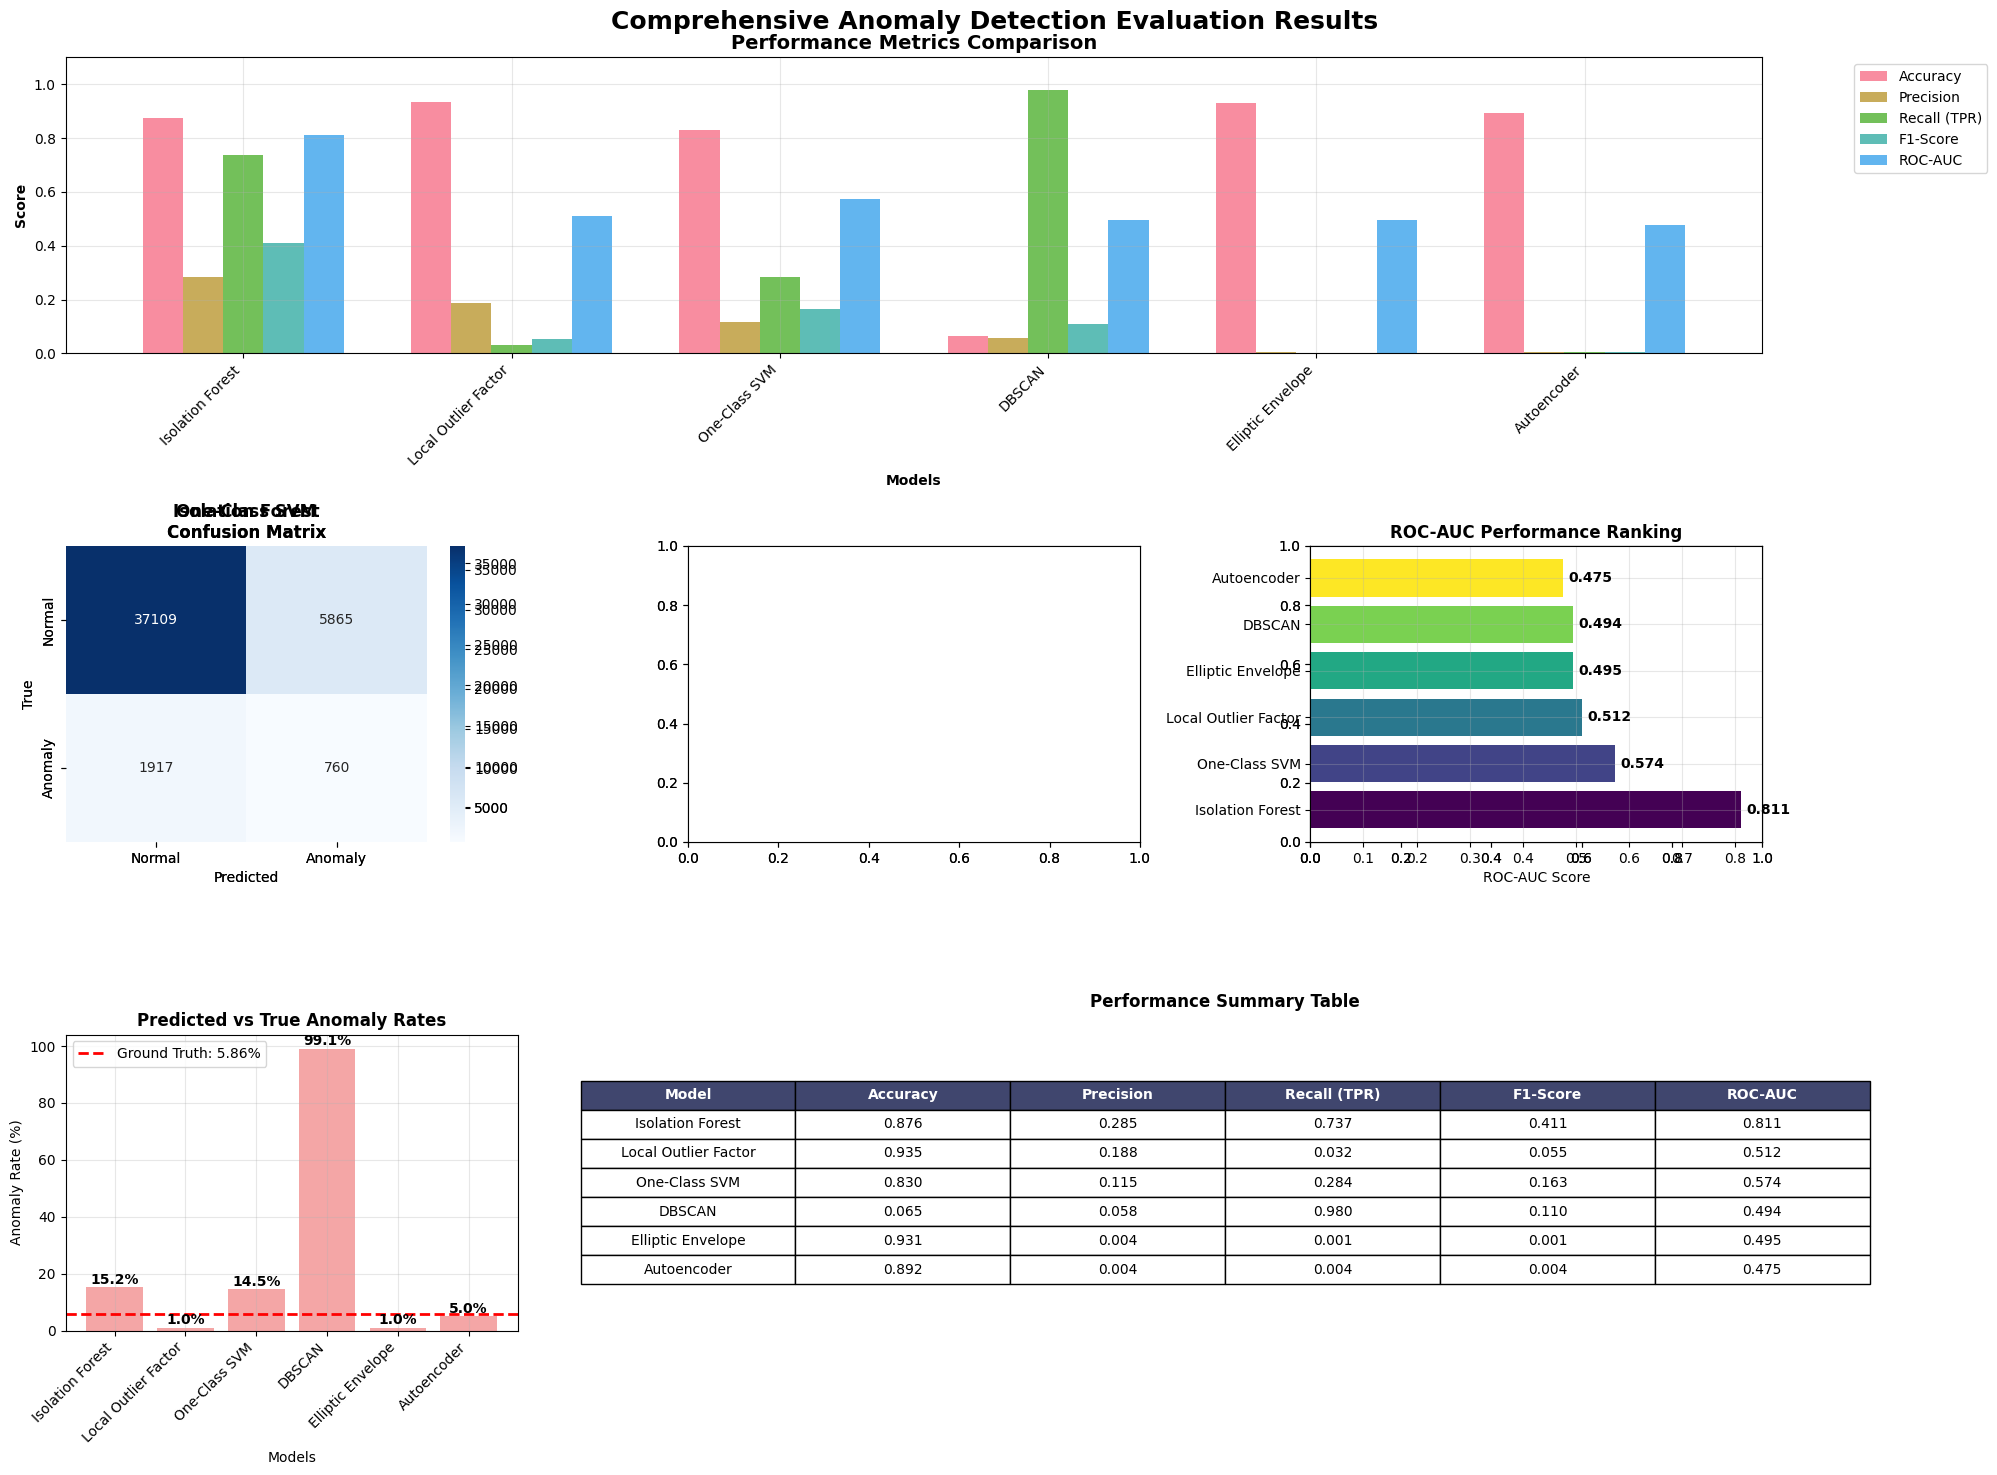


FINAL MODEL RANKING (by F1-Score):
   1. Isolation Forest
      F1-Score: 0.4106
      ROC-AUC: 0.8106
      Accuracy: 0.8760
   2. One-Class SVM
      F1-Score: 0.1634
      ROC-AUC: 0.5737
      Accuracy: 0.8295
   3. DBSCAN
      F1-Score: 0.1095
      ROC-AUC: 0.4943
      Accuracy: 0.0654
   4. Local Outlier Factor
      F1-Score: 0.0549
      ROC-AUC: 0.5117
      Accuracy: 0.9351
   5. Autoencoder
      F1-Score: 0.0040
      ROC-AUC: 0.4754
      Accuracy: 0.8918
   6. Elliptic Envelope
      F1-Score: 0.0013
      ROC-AUC: 0.4948
      Accuracy: 0.9310


In [10]:
# =============================================================================
# SECTION 8: COMPREHENSIVE ANOMALY DETECTION EVALUATION
# =============================================================================

def evaluate_anomaly_detection_comprehensive(y_true, predictions_dict, model_names=None):
    """
    Comprehensive evaluation of anomaly detection models with detailed metrics and visualizations
    """
    print("\nSTEP 9: COMPREHENSIVE ANOMALY DETECTION EVALUATION")
    print("=" * 65)

    if y_true is None:
        print(" No ground truth labels available - showing only prediction statistics")
        return None

    print("Evaluating anomaly detection performance against ground truth labels")
    print(f"Total test samples: {len(y_true):,}")

    # Ground truth statistics
    true_normal = (y_true == 0).sum()
    true_anomalies = (y_true == 1).sum()
    print(f"Ground truth: {true_normal:,} normal, {true_anomalies:,} anomalies ({true_anomalies/len(y_true)*100:.2f}%)")

    # Store all metrics
    evaluation_results = {}

    # Filter out non-prediction keys
    pred_keys = [k for k in predictions_dict.keys() if not k.endswith('_Errors')]

    print(f"\nCALCULATING METRICS FOR {len(pred_keys)} MODELS:")
    print("-" * 50)

    for model_name in pred_keys:
        if model_name not in predictions_dict:
            continue

        y_pred = predictions_dict[model_name]

        print(f"\nEvaluating {model_name}:")

        try:
            # Calculate comprehensive metrics
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)

            # ROC AUC (handle case where we might only have one class in predictions)
            try:
                roc_auc = roc_auc_score(y_true, y_pred)
            except ValueError:
                roc_auc = 0.5  # Random performance if only one class predicted

            # Confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)

            # Additional metrics
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
            false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

            # Store metrics
            metrics = {
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall (TPR)': recall,
                'Specificity (TNR)': specificity,
                'F1-Score': f1,
                'ROC-AUC': roc_auc,
                'False Positive Rate': false_positive_rate,
                'False Negative Rate': false_negative_rate,
                'True Positives': tp,
                'True Negatives': tn,
                'False Positives': fp,
                'False Negatives': fn
            }

            evaluation_results[model_name] = metrics

            # Print metrics
            print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
            print(f"   Precision: {precision:.4f} ({precision*100:.2f}%)")
            print(f"   Recall (Sensitivity): {recall:.4f} ({recall*100:.2f}%)")
            print(f"   Specificity: {specificity:.4f} ({specificity*100:.2f}%)")
            print(f"   F1-Score: {f1:.4f} ({f1*100:.2f}%)")
            print(f"   ROC-AUC: {roc_auc:.4f} ({roc_auc*100:.2f}%)")
            print(f"   Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

        except Exception as e:
            print(f"   Error calculating metrics: {str(e)}")
            continue

    return evaluation_results

def create_comprehensive_evaluation_visualizations(evaluation_results, predictions_dict, y_true):
    """
    Create comprehensive visualizations for anomaly detection evaluation
    """
    if not evaluation_results or y_true is None:
        return

    print(f"\nCREATING COMPREHENSIVE EVALUATION VISUALIZATIONS")
    print("=" * 60)

    n_models = len(evaluation_results)

    # Create large figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('Comprehensive Anomaly Detection Evaluation Results',
                 fontsize=18, fontweight='bold', y=0.98)

    # Create grid layout
    gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1])

    # 1. Performance Metrics Comparison
    ax1 = fig.add_subplot(gs[0, :])
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall (TPR)', 'F1-Score', 'ROC-AUC']
    model_names = list(evaluation_results.keys())

    x = np.arange(len(model_names))
    width = 0.15

    for i, metric in enumerate(metrics_to_plot):
        values = [evaluation_results[model][metric] for model in model_names]
        ax1.bar(x + i*width, values, width, label=metric, alpha=0.8)

    ax1.set_xlabel('Models', fontweight='bold')
    ax1.set_ylabel('Score', fontweight='bold')
    ax1.set_title('Performance Metrics Comparison', fontweight='bold', fontsize=14)
    ax1.set_xticks(x + width * 2)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.1)

    # 2. Confusion Matrix Heatmaps
    top_models = sorted(evaluation_results.items(),
                       key=lambda x: x[1]['F1-Score'], reverse=True)

    for idx, (model_name, metrics) in enumerate(top_models):
        ax = fig.add_subplot(gs[1, idx//2])
        if idx < 2:  # Only show first 2 models in second row

            y_pred = predictions_dict[model_name]
            cm = confusion_matrix(y_true, y_pred)

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                       xticklabels=['Normal', 'Anomaly'],
                       yticklabels=['Normal', 'Anomaly'])
            ax.set_title(f'{model_name}\nConfusion Matrix', fontweight='bold')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')

    # 3. ROC-AUC Ranking
    ax3 = fig.add_subplot(gs[1, 2])
    roc_scores = [(model, metrics['ROC-AUC']) for model, metrics in evaluation_results.items()]
    roc_scores.sort(key=lambda x: x[1], reverse=True)

    models, scores = zip(*roc_scores)
    colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
    bars = ax3.barh(range(len(models)), scores, color=colors)
    ax3.set_yticks(range(len(models)))
    ax3.set_yticklabels(models)
    ax3.set_xlabel('ROC-AUC Score')
    ax3.set_title('ROC-AUC Performance Ranking', fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, scores)):
        ax3.text(score + 0.01, bar.get_y() + bar.get_height()/2,
                f'{score:.3f}', va='center', fontweight='bold')

    # 4. Prediction Distribution Comparison
    ax4 = fig.add_subplot(gs[2, 0])
    pred_keys = [k for k in predictions_dict.keys() if not k.endswith('_Errors')]
    anomaly_rates = []

    for model_name in pred_keys:
        if model_name in predictions_dict:
            pred = predictions_dict[model_name]
            anomaly_rate = (pred == 1).sum() / len(pred) * 100
            anomaly_rates.append(anomaly_rate)

    # Ground truth anomaly rate
    true_anomaly_rate = (y_true == 1).sum() / len(y_true) * 100

    x_pos = np.arange(len(pred_keys))
    bars = ax4.bar(x_pos, anomaly_rates, alpha=0.7, color='lightcoral')
    ax4.axhline(y=true_anomaly_rate, color='red', linestyle='--', linewidth=2,
               label=f'Ground Truth: {true_anomaly_rate:.2f}%')

    ax4.set_xlabel('Models')
    ax4.set_ylabel('Anomaly Rate (%)')
    ax4.set_title('Predicted vs True Anomaly Rates', fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(pred_keys, rotation=45, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, rate in zip(bars, anomaly_rates):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 5. Model Performance Summary Table
    ax5 = fig.add_subplot(gs[2, 1:])
    ax5.axis('tight')
    ax5.axis('off')

    # Create summary table
    summary_metrics = ['Accuracy', 'Precision', 'Recall (TPR)', 'F1-Score', 'ROC-AUC']
    table_data = []

    for model_name in evaluation_results.keys():
        row = [model_name] + [f"{evaluation_results[model_name][metric]:.3f}"
                             for metric in summary_metrics]
        table_data.append(row)

    table = ax5.table(cellText=table_data,
                     colLabels=['Model'] + summary_metrics,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)

    # Style the table
    for i in range(len(summary_metrics) + 1):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')

    ax5.set_title('Performance Summary Table', fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

# ==========================================================
# EXECUTION
# ==========================================================

# Evaluate all models
if y_test is not None:
    evaluation_results = evaluate_anomaly_detection_comprehensive(y_test, anomaly_predictions)

    if evaluation_results:
        # Create comprehensive visualizations
        create_comprehensive_evaluation_visualizations(evaluation_results, anomaly_predictions, y_test)

        # Print final ranking
        print(f"\nFINAL MODEL RANKING (by F1-Score):")
        print("=" * 45)
        ranked_models = sorted(evaluation_results.items(),
                             key=lambda x: x[1]['F1-Score'], reverse=True)

        for rank, (model_name, metrics) in enumerate(ranked_models, 1):
            print(f"   {rank}. {model_name}")
            print(f"      F1-Score: {metrics['F1-Score']:.4f}")
            print(f"      ROC-AUC: {metrics['ROC-AUC']:.4f}")
            print(f"      Accuracy: {metrics['Accuracy']:.4f}")
else:
    print("No ground truth labels available for evaluation")


# Section 9 - ROC-AUC Performance measurement

## Goal
- Plot a ROC-AUC for the models
- Rank the models by ROC-AUC


ROC CURVES VISUALIZATION

PLOTTING ROC CURVES FOR ALL MODELS
Processing 6 models for ROC analysis...
   ✅ Isolation Forest     | AUC: 0.8106
   ✅ Local Outlier Factor | AUC: 0.5117
   ✅ One-Class SVM        | AUC: 0.5737
   ✅ DBSCAN               | AUC: 0.4943
   ✅ Elliptic Envelope    | AUC: 0.4948
   ✅ Autoencoder          | AUC: 0.4754


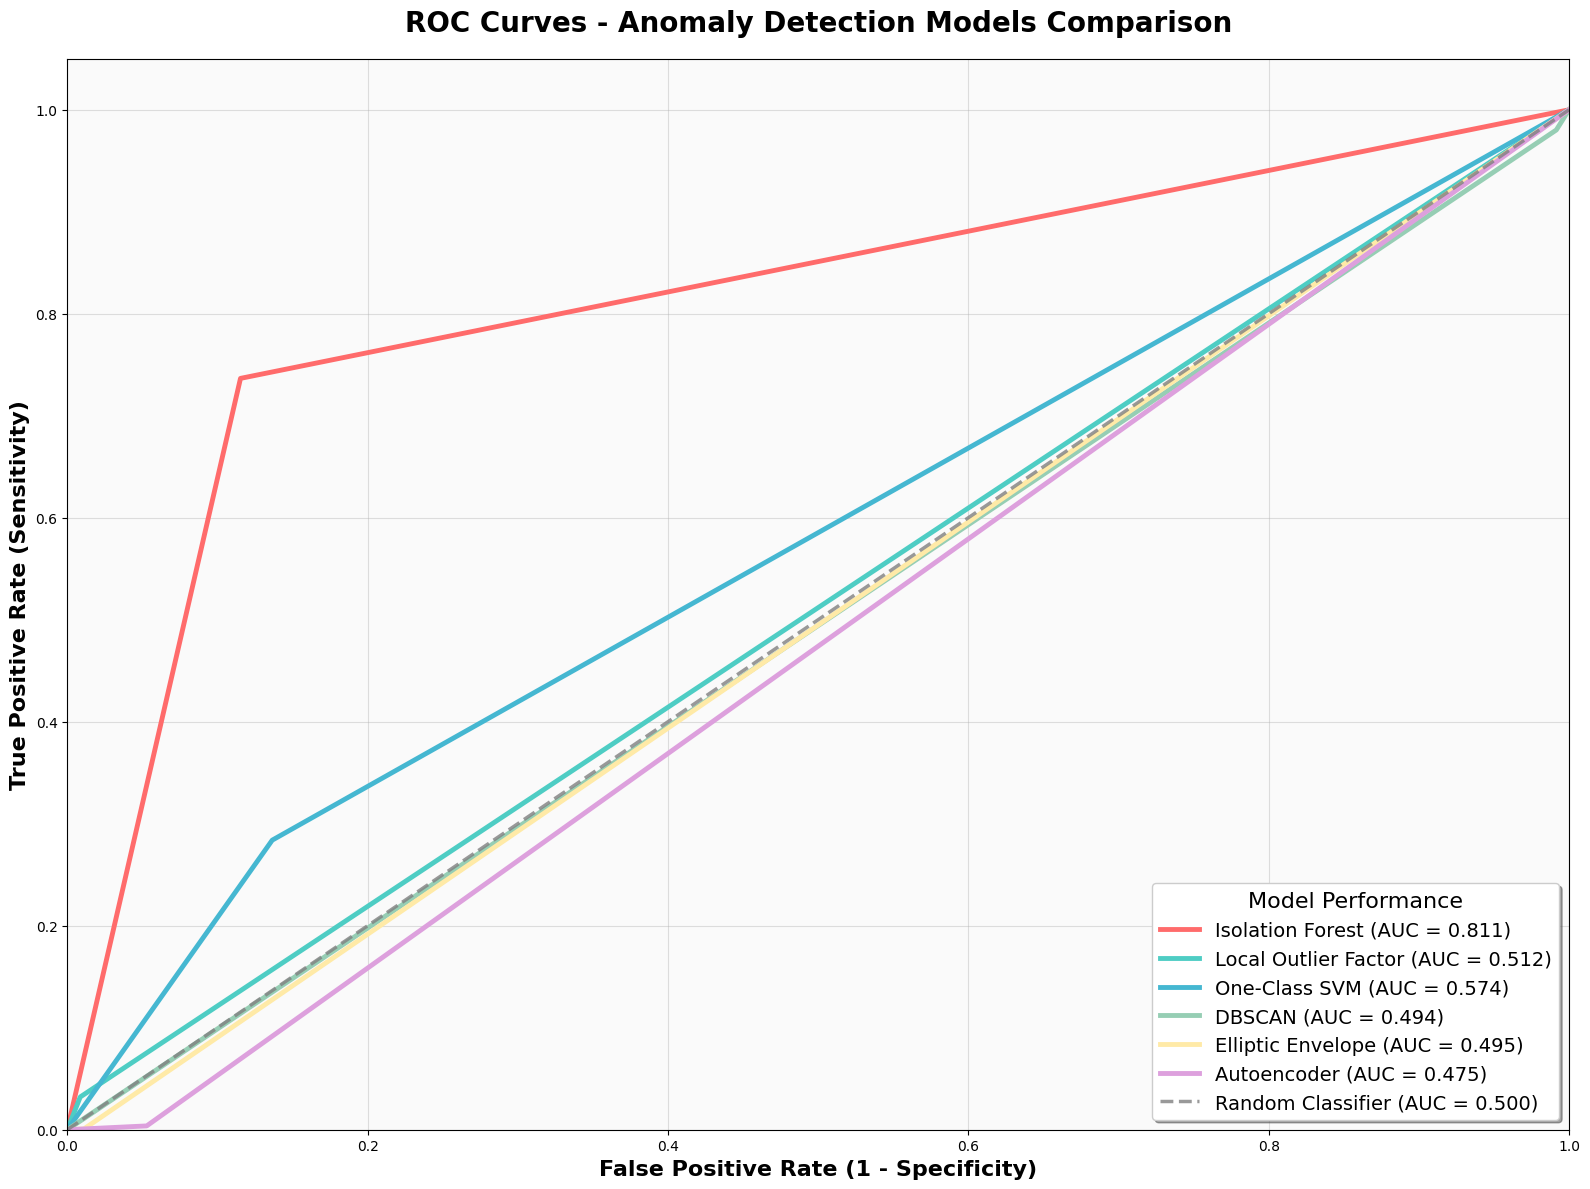


✅ ROC curves plotted successfully!


In [11]:
# =============================================================================
# SECTION 9A: ROC CURVES VISUALIZATION
# =============================================================================

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

def plot_roc_curves_large(y_true, predictions_dict, figsize=(16, 12)):
    """
    Plot large ROC curves for all anomaly detection models

    Parameters:
    - y_true: True binary labels (0 for normal, 1 for anomaly)
    - predictions_dict: Dictionary containing model predictions/scores
    - figsize: Figure size tuple (width, height)
    """
    print("\nPLOTTING ROC CURVES FOR ALL MODELS")
    print("=" * 50)

    plt.figure(figsize=figsize)

    # Color palette for models
    model_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7',
                   '#DDA0DD', '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9']

    auc_scores = {}

    # Filter out error/score keys and process only prediction keys
    pred_keys = [k for k in predictions_dict.keys() if not k.endswith('_Errors')]

    print(f"Processing {len(pred_keys)} models for ROC analysis...")

    for i, model_name in enumerate(pred_keys):
        if model_name not in predictions_dict:
            continue

        try:
            predictions = predictions_dict[model_name]

            # Handle different prediction formats
            if isinstance(predictions, (list, tuple)) and len(predictions) == 2:
                # For models returning (predictions, scores) tuples
                pred_binary, pred_scores = predictions
                if hasattr(pred_scores, '__len__') and len(pred_scores) == len(y_true):
                    y_scores = pred_scores
                else:
                    y_scores = pred_binary
            else:
                # Single array of predictions or scores
                y_scores = predictions

            # Convert to numpy array if needed
            if hasattr(y_scores, 'values'):
                y_scores = y_scores.values
            y_scores = np.array(y_scores)

            # Calculate ROC curve
            fpr, tpr, thresholds = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)

            # Store AUC score
            auc_scores[model_name] = roc_auc

            # Plot ROC curve with thicker lines
            color = model_colors[i % len(model_colors)]
            plt.plot(fpr, tpr, color=color, lw=3.5,
                    label=f'{model_name} (AUC = {roc_auc:.3f})')

            print(f"   ✅ {model_name:<20} | AUC: {roc_auc:.4f}")

        except Exception as e:
            print(f"{model_name:<20} | Error: {str(e)}")
            continue

    # Plot diagonal line (random classifier baseline)
    plt.plot([0, 1], [0, 1], color='gray', lw=2.5, linestyle='--', alpha=0.8,
             label='Random Classifier (AUC = 0.500)')

    # Customize ROC plot with larger fonts
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=16, fontweight='bold')
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=16, fontweight='bold')
    plt.title('ROC Curves - Anomaly Detection Models Comparison', fontsize=20, fontweight='bold', pad=20)

    # Larger legend
    plt.legend(loc="lower right", frameon=True, fancybox=True, shadow=True,
               fontsize=14, title='Model Performance', title_fontsize=16)

    # Enhanced grid
    plt.grid(True, alpha=0.4, linestyle='-', linewidth=0.8)

    # Add subtle background coloring for better visual appeal
    plt.gca().set_facecolor('#FAFAFA')

    plt.tight_layout()
    plt.show()

    return auc_scores


# ==========================================================
# EXECUTION - ROC CURVES PLOT
# ==========================================================

try:
    print(f"\n{'='*70}")
    print("ROC CURVES VISUALIZATION")
    print(f"{'='*70}")

    # Check if required variables exist
    if 'y_test' not in locals() or y_test is None:
        print("No ground truth labels (y_test) available for ROC analysis")
    elif 'anomaly_predictions' not in locals() or not anomaly_predictions:
        print("No model predictions (anomaly_predictions) available for ROC analysis")
    else:
        # Plot large ROC curves
        auc_results = plot_roc_curves_large(y_test, anomaly_predictions, figsize=(16, 12))
        print(f"\n✅ ROC curves plotted successfully!")

except Exception as e:
    print(f"ROC curves plotting failed: {str(e)}")
    import traceback
    traceback.print_exc()



AUC SCORES RANKING VISUALIZATION

PLOTTING AUC SCORES RANKING


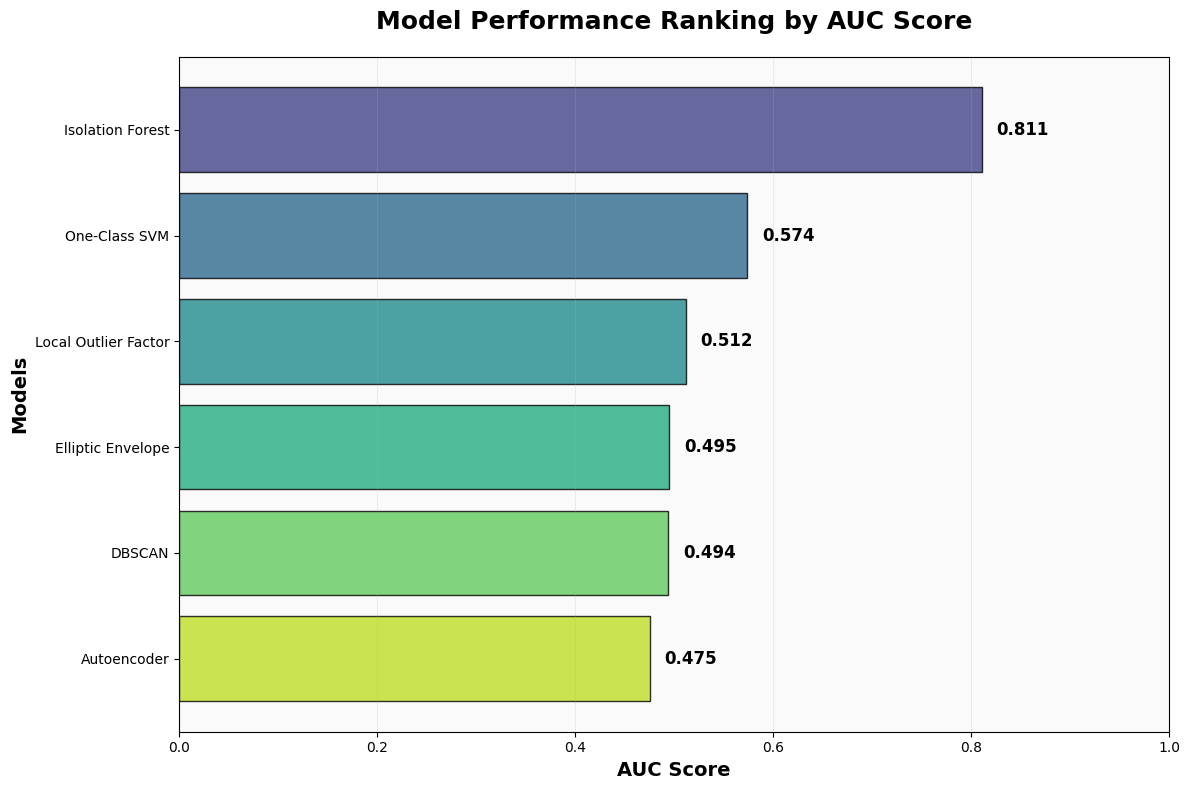

\AUC SCORES RANKING:
------------------------------
    1. Isolation Forest          | 0.8106
    2. One-Class SVM             | 0.5737
    3. Local Outlier Factor      | 0.5117
    4. Elliptic Envelope         | 0.4948
    5. DBSCAN                    | 0.4943
    6. Autoencoder               | 0.4754

AUC SUMMARY STATISTICS:
-----------------------------------
   Highest AUC: 0.8106
   Lowest AUC: 0.4754
   Average AUC: 0.5601
   Median AUC: 0.5033
   Std Deviation: 0.1162
   Models Count: 6

AUC scores ranking completed successfully!


In [12]:
# =============================================================================
# SECTION 9B: AUC SCORES RANKING VISUALIZATION
# =============================================================================


def plot_auc_scores_ranking(auc_scores, figsize=(12, 8)):
    """
    Plot AUC scores ranking as horizontal bar chart

    Parameters:
    - auc_scores: Dictionary with model names as keys and AUC scores as values
    - figsize: Figure size tuple
    """
    if not auc_scores:
        print("No AUC scores available for plotting")
        return

    print("\nPLOTTING AUC SCORES RANKING")
    print("=" * 40)

    # Sort models by AUC score (descending)
    sorted_models = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)
    models, scores = zip(*sorted_models)

    # Create figure
    plt.figure(figsize=figsize)

    # Create color gradient based on score
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(models)))

    # Create horizontal bar chart
    bars = plt.barh(range(len(models)), scores, color=colors, alpha=0.8,
                   edgecolor='black', linewidth=1)

    # Customize chart
    plt.yticks(range(len(models)), models)
    plt.gca().invert_yaxis()  # Highest score at top
    plt.xlim(0, 1.0)
    plt.xlabel('AUC Score', fontsize=14, fontweight='bold')
    plt.ylabel('Models', fontsize=14, fontweight='bold')
    plt.title('Model Performance Ranking by AUC Score', fontsize=18, fontweight='bold', pad=20)

    # Add grid
    plt.grid(True, alpha=0.3, axis='x', linestyle='-', linewidth=0.5)

    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, scores)):
        plt.text(score + 0.015, bar.get_y() + bar.get_height()/2,
                f'{score:.3f}', va='center', ha='left',
                fontweight='bold', fontsize=12)

    # Add background color
    plt.gca().set_facecolor('#FAFAFA')

    # Tight layout
    plt.tight_layout()
    plt.show()

    # Print ranking summary
    print(f"\AUC SCORES RANKING:")
    print("-" * 30)
    for i, (model, score) in enumerate(sorted_models, 1):
        print(f"   {i:2d}. {model:<25} | {score:.4f}")

    return sorted_models


def create_auc_summary_statistics(auc_scores):
    """
    Create summary statistics for AUC scores
    """
    if not auc_scores:
        return

    scores = list(auc_scores.values())

    print(f"\nAUC SUMMARY STATISTICS:")
    print("-" * 35)
    print(f"   Highest AUC: {max(scores):.4f}")
    print(f"   Lowest AUC: {min(scores):.4f}")
    print(f"   Average AUC: {np.mean(scores):.4f}")
    print(f"   Median AUC: {np.median(scores):.4f}")
    print(f"   Std Deviation: {np.std(scores):.4f}")
    print(f"   Models Count: {len(auc_scores)}")


# ==========================================================
# EXECUTION - AUC SCORES RANKING
# ==========================================================

try:
    print(f"\n{'='*70}")
    print("AUC SCORES RANKING VISUALIZATION")
    print(f"{'='*70}")

    # Check if AUC results exist from previous cell
    if 'auc_results' not in locals() or not auc_results:
        print("No AUC results available. Run ROC curves cell first.")
    else:
        # Plot AUC scores ranking
        model_ranking = plot_auc_scores_ranking(auc_results, figsize=(12, 8))

        # Create summary statistics
        create_auc_summary_statistics(auc_results)

        print(f"\nAUC scores ranking completed successfully!")

except Exception as e:
    print(f"AUC scores plotting failed: {str(e)}")
    import traceback
    traceback.print_exc()
